### Todos
- (Alex) no complex logic in preprocessing (What Danni said implementing)
- Reduce Model
- Explainable AI 
- Markdown writing and explaine what we have done
- Clean up code: (Imports in central place, Comments, Code Refactor)

# Setup
Die folgenden Code-Blöcke können genutzt werden, um die benötigten Abhängigkeiten zu installieren und zu importieren.

In [1]:
%%capture
%pip install -r ../requirements.txt


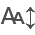

In [2]:
from itables import show
from itables import init_notebook_mode

init_notebook_mode(all_interactive=True)


In [3]:
# Laden der eingesetzten Libraries
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
from IPython.display import display
from itables import init_notebook_mode
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import cosine_similarity

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import (
    cross_val_score,
    GridSearchCV,
    StratifiedKFold,
)
from sklearn.metrics import (
    roc_curve,
    auc,
    make_scorer,
    fbeta_score,
    cohen_kappa_score,
    matthews_corrcoef,
)
import lime.lime_tabular
import shap

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from tqdm import tqdm
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

In [4]:
%%capture
# set theme ggplot for plots
plt.style.use("ggplot")
# set display options
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [5]:
# Funktion zur Bestimmung des Geschlechts und Berechnung des Geburtstags
def parse_details(birth_number):
    birth_number_str = str(
        birth_number
    )  # Konvertiere birth_number zu einem String, falls notwendig
    year_prefix = "19"
    month = int(birth_number_str[2:4])
    gender = "female" if month > 12 else "male"
    if gender == "female":
        month -= 50
    year = int(year_prefix + birth_number_str[:2])
    day = int(birth_number_str[4:6])
    birth_day = datetime(year, month, day)
    return gender, birth_day


# Berechnung des Alters basierend auf einem Basisjahr
def calculate_age(birth_date, base_date=datetime(1999, 12, 31)):
    return (
        base_date.year
        - birth_date.year
        - ((base_date.month, base_date.day) < (birth_date.month, birth_date.day))
    )


# Regression metrics
def regression_results(y_true, y_pred):
    print(
        "explained_variance: ",
        round(metrics.explained_variance_score(y_true, y_pred), 4),
    )
    print(
        "mean_squared_log_error: ",
        round(metrics.mean_squared_log_error(y_true, y_pred), 4),
    )
    print("r2: ", round(metrics.r2_score(y_true, y_pred), 4))
    print("MAE: ", round(metrics.mean_absolute_error(y_true, y_pred), 4))
    print("MSE: ", round(metrics.mean_squared_error(y_true, y_pred), 4))
    print("RMSE: ", round(np.sqrt(metrics.mean_squared_error(y_true, y_pred)), 4))

# Aufgabenstellung
Inhalt der hier bearbeiteten und dokumentierten Mini-Challenge für das Modul «aml - Angewandtes Machine Learning» der FHNW ist die Entwicklung und Evaluierung von Aﬀinitätsmodellen für personalisierte Kreditkarten-Werbekampagnen im Auftrag einer Bank. Das Ziel der Authoren ist es also, mithilfe von Kunden- und Transaktionsdaten präzise Modelle zu erstellen, die die Wahrscheinlichkeit des Kreditkartenkaufs einer bestimmten Person vorhersagen.

# Laden der zur Verfügung gestellten Daten
[//]: # (-.- .tabset)

Zur Verfügung gestellt wurden 8 csv-Dateien von welchen die Beschreibung der erfassten Variablen unter dem folgenden Link eingesehen werden können: [PKDD'99 Discovery Challenge - Guide to the Financial Data Set](https://sorry.vse.cz/~berka/challenge/PAST/index.html). Nachfolgend werden diese csv-Dateien eingelesen.

In [6]:
account = pd.read_csv("./data/account.csv", sep=";", dtype={"date": "str"})
card = pd.read_csv("./data/card.csv", sep=";", dtype={"issued": "str"})
client = pd.read_csv("./data/client.csv", sep=";")
disp = pd.read_csv("./data/disp.csv", sep=";")
district = pd.read_csv("./data/district.csv", sep=";")
loan = pd.read_csv("./data/loan.csv", sep=";", dtype={"date": "str"})
order = pd.read_csv("./data/order.csv", sep=";")
trans = pd.read_csv("./data/trans.csv", sep=";", dtype={"date": "str", "bank": "str"})

# Datenaufbereitung & Explorative Datenanalyse
Im folgenden Abschnitt werden die geladenen Daten separat so transformiert, dass jede Zeile einer Observation und jede Spalte einer Variable im entsprechenden Datenformat entspricht, also ins Tidy-Format gebracht.

In [7]:
data_frames = {}

## Account
[//]: # (-.- .tabset)
Der Datensatz `accounts.csv` beinhaltet 4500 Observationen mit den folgenden Informationen über die Kontos der Bank:  
- `account_id`: die Kontonummer, 
- `district_id`: den Standort der entsprechenden Bankfiliale,
- `frequency`: die Frequenz der Ausstellung von Kontoauszügen (monatlich, wöchentlich, pro Transaktion) und 
- `date`: das Erstellungsdatum

In [8]:
account.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   account_id   4500 non-null   int64 
 1   district_id  4500 non-null   int64 
 2   frequency    4500 non-null   object
 3   date         4500 non-null   object
dtypes: int64(2), object(2)
memory usage: 140.8+ KB


In [9]:
print("Anzahl fehlender Werte:", sum(account.isnull().sum()))
print("Anzahl duplizierter Einträge:", account.duplicated().sum())

Anzahl fehlender Werte: 0
Anzahl duplizierter Einträge: 0


### Aufbereitung
Nachfolgend wird die `date` Spalte des `account.csv`-Datensatzes in das entsprechende Datenformat geparsed und die Werte von `frequency` übersetzt und als Levels einer Kategorie definiert.

In [10]:
# parse date
account["date"] = pd.to_datetime(account["date"], format="%y%m%d")
# translate categories
account["frequency"] = account["frequency"].replace(
    {
        "POPLATEK MESICNE": "monthly",
        "POPLATEK TYDNE": "weekly",
        "POPLATEK PO OBRATU": "transactional",
    }
)

# convert column frequency to categorical
account["frequency"] = account["frequency"].astype("category")

# sample 5 random rows
account.sample(n=5)

account_id  district_id frequency       date
2844         587           19   monthly 1996-06-21
3020        4071           64   monthly 1996-08-03
3578        7045           51   monthly 1996-12-26
4128        5758           44   monthly 1997-07-28
3857        3077           64   monthly 1997-04-16

### Distrikt
Hier zu sehen ist die Verteilung der Distrikte pro Bankkonto. Ersichtlich ist, dass im Distrikt 1 mit Abstand am meisten Bankkontos geführt werden. Die darauf folgenden Distrikte bewegen sich alle im Bereich zwischen ~250 - 50 Bankkonten.  

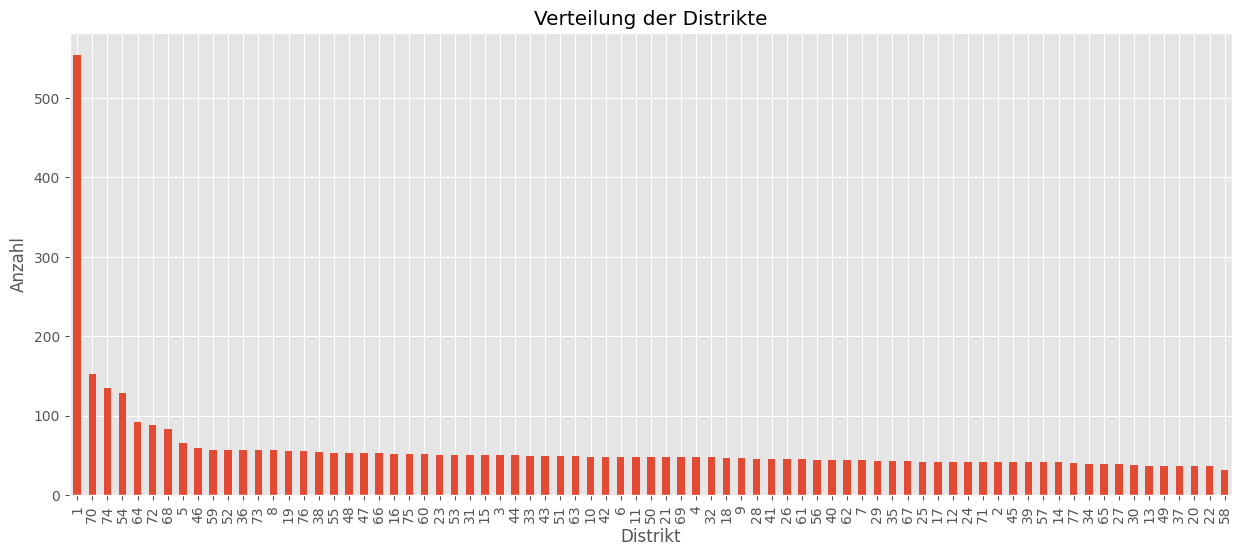

In [11]:
# plot the distribution of the district_ids and replace the id with it's name
plt.figure(figsize=(15, 6))
account["district_id"].value_counts().plot(kind="bar")
plt.title("Verteilung der Distrikte")
plt.xlabel("Distrikt")
plt.ylabel("Anzahl")
plt.show()

### Frequenz
Auf dieser Visualisierung zu sehen ist die Klassenverteilung der Frequenz der Ausstellung der Kontoauszüge. Die allermeisten Bankkonten besitzen eine monatliche Ausstellung.

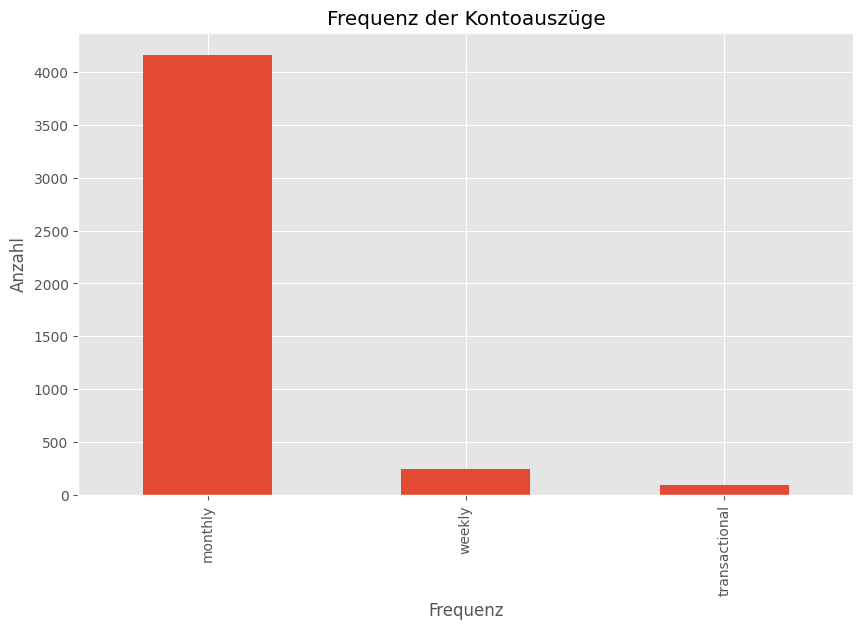

In [12]:
# Verteilung der Frequenz visualisieren
plt.figure(figsize=(10, 6))
account["frequency"].value_counts().plot(kind="bar")
plt.title("Frequenz der Kontoauszüge")
plt.xlabel("Frequenz")
plt.ylabel("Anzahl")
plt.show()

### Datum
Der hier dargestellte Plot zeigt die Verteilung der Kontoerstellungsdaten. Das erste Konto wurde im Jahr 1993 und das neuste im 1998 erstellt.  

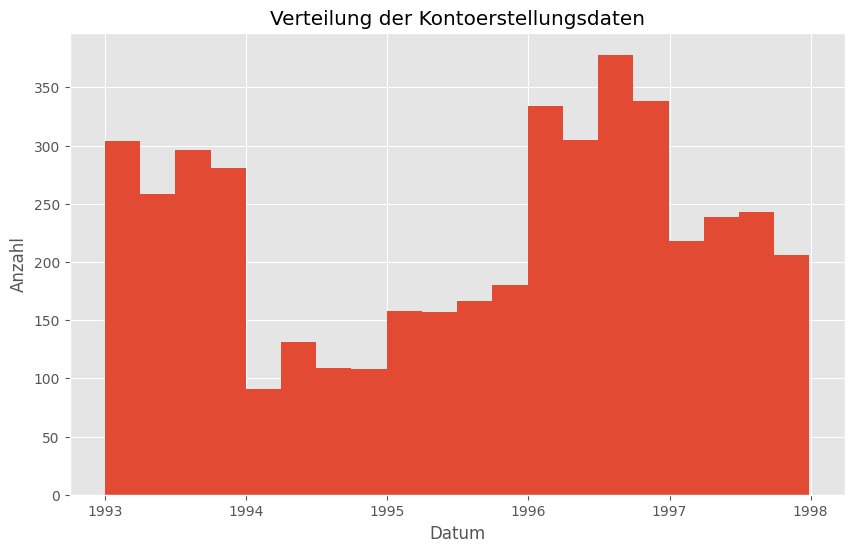

In [13]:
# plot date distribution
plt.figure(figsize=(10, 6))
plt.hist(account["date"], bins=20)
plt.title("Verteilung der Kontoerstellungsdaten")
plt.xlabel("Datum")
plt.ylabel("Anzahl")
plt.show()

### Korrelation & weitere Informationen
Die Korrelation sowie weitere Informationen zu den vorhandenen Daten können aus dem [SweetViz Report](./reports/accounts.html) entnommen werden. 

In [14]:
# append account data to dataframe collection
data_frames["account.csv"] = account

In [15]:
# %%capture
# # generate sweetviz report
# svReport_account = sv.analyze(account)
# svReport_account.show_html(filepath="./reports/accounts.html", open_browser=False)

## Card
[//]: # (-.- .tabset)

Der Datensatz `card.csv` beinhaltet 892 Observationen mit den folgenden Informationen über die von der Bank herausgegebenen Kreditkarten:  
- `card_id`: die Kartennummer, 
- `disp_id`: die Zuordnung zum entsprechenden Bankkonto und -inhaber (Disposition),
- `type`: die Art der Kreditkarte (junior, classic, gold) und 
- `issued`: das Ausstellungsdatum

In [16]:
card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892 entries, 0 to 891
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   card_id  892 non-null    int64 
 1   disp_id  892 non-null    int64 
 2   type     892 non-null    object
 3   issued   892 non-null    object
dtypes: int64(2), object(2)
memory usage: 28.0+ KB


In [17]:
print("Anzahl fehlender Werte:", sum(card.isnull().sum()))
print("Anzahl duplizierter Einträge:", card.duplicated().sum())

Anzahl fehlender Werte: 0
Anzahl duplizierter Einträge: 0


### Aufbereitung
Auch bei diesem Datensatz (`card.csv`) werden zunächst die Datentypen korrigiert um anschliessend die Inhalte entsprechend beschreiben zu können

In [18]:
# parse date
card["issued"] = pd.to_datetime(card["issued"].str[:6], format="%y%m%d")
card["issued"] = card["issued"].dt.to_period("M")
# convert type to categorical
card["type"] = card["type"].astype("category")

card.sample(n=5)

card_id  disp_id     type   issued
335      140      798  classic  1997-08
154       12       83   junior  1996-09
872      735     4772  classic  1998-12
267      399     2527  classic  1997-05
378      638     4100     gold  1997-10

### Kartentyp
Hier dargestellt ist die Klassenverteilung der Kartentypen. Die meisten Karteninhaber besitzen eine klassische Kreditkarte, gefolgt von ~180 junior- und ~100 gold Karten.  

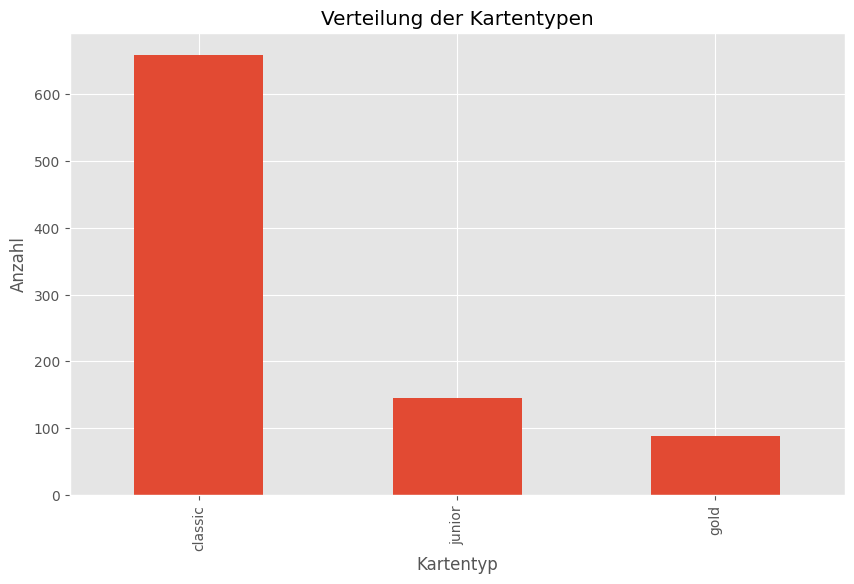

In [19]:
# plot distribution of type
plt.figure(figsize=(10, 6))
card["type"].value_counts().plot(kind="bar")
plt.title("Verteilung der Kartentypen")
plt.xlabel("Kartentyp")
plt.ylabel("Anzahl")
plt.show()

### Ausstellungsdatum
Hier dargestellt ist die Häufigkeit von Kreditkartenausstellungen pro Monat. Erkennbar ist eine steigende Tendenz mit einem Rückgang in den Monaten Februar - April 1997.  

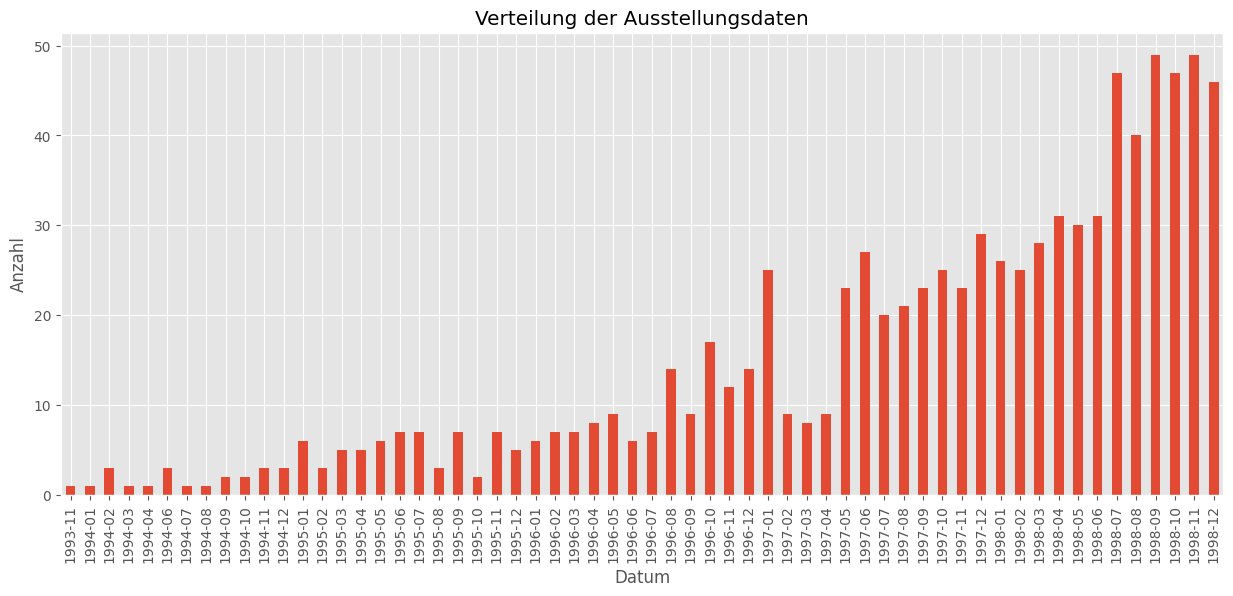

In [20]:
# plot issued date per month and year
plt.figure(figsize=(15, 6))
card["issued"].value_counts().sort_index().plot(kind="bar")
plt.title("Verteilung der Ausstellungsdaten")
plt.xlabel("Datum")
plt.ylabel("Anzahl")
plt.show()

### Korrelation & weitere Informationen
Die Korrelation sowie weitere Informationen zu den vorhandenen Daten können aus dem [SweetViz Report](./reports/card.html) entnommen werden.

In [21]:
# append to dataframes collection
data_frames["card.csv"] = card

In [22]:
# %%capture
# # generate sweetviz report
# svReport_card = sv.analyze(card)
# svReport_card.show_html(filepath="./reports/card.html", open_browser=False)

## Client
[//]: # (-.- .tabset)

Der Datensatz `client.csv` beinhaltet 5369 Observationen mit den folgenden Informationen über die Kunden der Bank:  
- `client_id`: die Kundennummer, 
- `birth_number`: eine Kombination aus Geburtsdatum und Geschlecht sowie
- `district_id`: die Adresse  

In [23]:
client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5369 entries, 0 to 5368
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   client_id     5369 non-null   int64
 1   birth_number  5369 non-null   int64
 2   district_id   5369 non-null   int64
dtypes: int64(3)
memory usage: 126.0 KB


In [24]:
print("Anzahl fehlender Werte:", sum(client.isnull().sum()))
print("Anzahl duplizierter Einträge:", client.duplicated().sum())

Anzahl fehlender Werte: 0
Anzahl duplizierter Einträge: 0


### Aufbereitung
Die Spalte `birth_number` des `client.csv`-Datensatzes codiert 3 Features der Bankkunden: Geschlecht, Geburtsdatum und damit auch das Alter. Diese Informationen werden mithilfe der zuvor definierten Funktionen `parse_details()` und `calculate_age` extrahiert.

In [25]:
# Geburtstag & Geschlecht aus birth_number extrahieren
client["gender"], client["birth_day"] = zip(
    *client["birth_number"].apply(parse_details)
)
client["gender"] = client["gender"].astype("category")
# Alter berechnen
client["age"] = client["birth_day"].apply(calculate_age)

# Spalte birth_number entfernen
client = client.drop(columns=["birth_number"])

# Sample 5 random rows
client.sample(n=5)

client_id  district_id  gender  birth_day  age
5106      10543           14  female 1945-02-23   54
954        1008            6    male 1956-07-06   43
1384       1463           70  female 1936-01-26   63
5235      12133           27  female 1964-06-26   35
365         386           62    male 1980-08-21   19

### Geschlecht
Hier dargestellt ist die Verteilung des Geschlechts der Bankkunden. Das Geschlecht der erfassten Bankkunden ist fast gleichverteilt mit einem etwas kleineren Frauenanteil.  

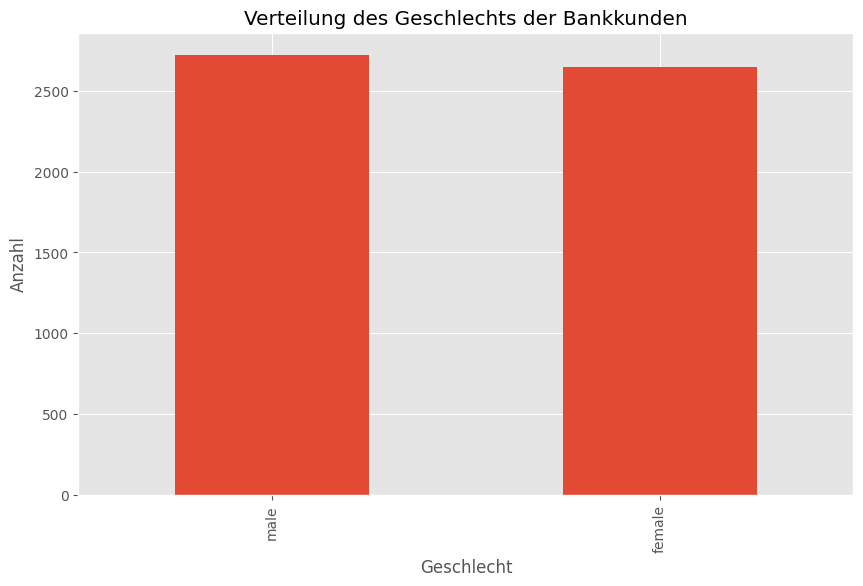

In [26]:
# plot distribution of gender
plt.figure(figsize=(10, 6))
gender_distribution = client["gender"].value_counts().plot(kind="bar")
plt.title("Verteilung des Geschlechts der Bankkunden")
plt.xlabel("Geschlecht")
plt.ylabel("Anzahl")
plt.show()

### Alter
Nachfolgend abgebildet ist die Verteilung des Alters der Bankkunden. Die jüngste erfasste Person ist 12 Jahre alt und die älteste 88. 

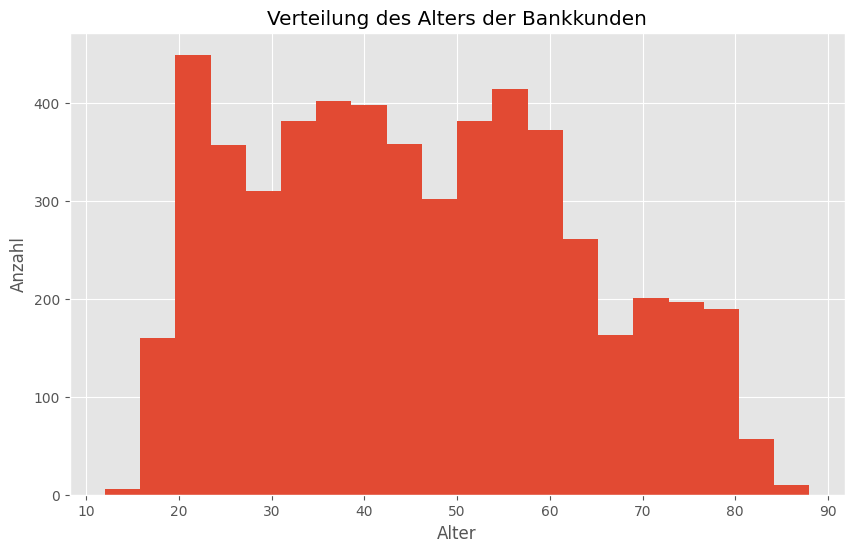

In [27]:
# plot distribution of age
plt.figure(figsize=(10, 6))
client["age"].plot(kind="hist", bins=20)
plt.title("Verteilung des Alters der Bankkunden")
plt.xlabel("Alter")
plt.ylabel("Anzahl")
plt.show()

### Korrelation & weitere Informationen
Die Korrelation sowie weitere Informationen zu den vorhandenen Daten können aus dem [SweetViz Report](./reports/client.html) entnommen werden.

In [28]:
data_frames["client.csv"] = client

In [29]:
# %%capture
# svReport_client = sv.analyze(client)
# svReport_client.show_html(filepath="./reports/client.html", open_browser=False)

## Disp
[//]: # (-.- .tabset)

Der Datensatz `disp.csv` beinhaltet 5369 Observationen mit den folgenden Informationen über die Dispositionen der Bank:  
- `disp_id`: der Identifikationsschlüssel der Disposition,
- `client_id`: die Kundennummer,
- `account_id`: die Kontonummer,
- `type`: die Art der Disposition (Inhaber, Benutzer)

In [30]:
disp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5369 entries, 0 to 5368
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   disp_id     5369 non-null   int64 
 1   client_id   5369 non-null   int64 
 2   account_id  5369 non-null   int64 
 3   type        5369 non-null   object
dtypes: int64(3), object(1)
memory usage: 167.9+ KB


In [31]:
print("Anzahl fehlender Werte:", sum(disp.isnull().sum()))
print("Anzahl duplizierter Einträge:", disp.duplicated().sum())

Anzahl fehlender Werte: 0
Anzahl duplizierter Einträge: 0


### Aufbereitung
Auch die Variablen des Datensatzes `disp.csv` werden in die korrekten Datentypen übertragen. 

In [32]:
# Spalte type als Kategorie speichern
disp["type"] = disp["type"].astype("category")

# random sample
disp.sample(n=5)

disp_id  client_id  account_id       type
3053     3222       3222        2668      OWNER
1900     2013       2013        1660      OWNER
678       711        711         593      OWNER
1367     1445       1445        1197      OWNER
1270     1336       1336        1114  DISPONENT

### Typ der Disposition
Hier dargestellt ist die Verteilung der Art der Dispositionen. 4500 Kunden sind Inhaber eines Kontos und 896 sind Disponenten. 

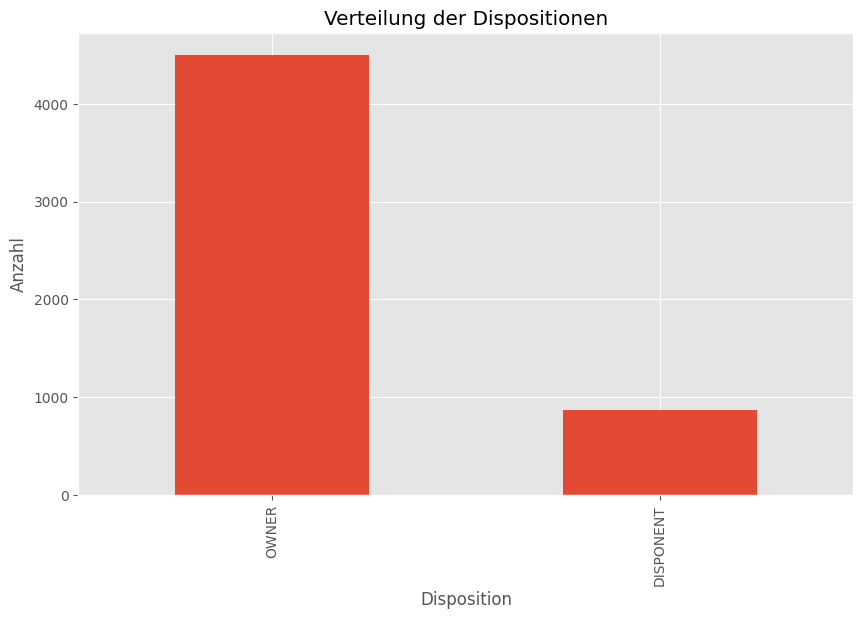

In [33]:
# plot distribution of kind
plt.figure(figsize=(10, 6))
disp["type"].value_counts().plot(kind="bar")
plt.title("Verteilung der Dispositionen")
plt.xlabel("Disposition")
plt.ylabel("Anzahl")
plt.show()

In [34]:
# remove disponents
disp = disp[disp["type"] == "OWNER"]

### Korrelation & weitere Informationen
Die Korrelation sowie weitere Informationen zu den vorhandenen Daten können aus dem [SweetViz Report](./reports/disp.html) entnommen werden.

In [35]:
data_frames["disp.csv"] = disp

In [36]:
# %%capture
# svReport_disp = sv.analyze(disp)
# svReport_disp.show_html(filepath="./reports/disp.html", open_browser=False)

## District
[//]: # (-.- .tabset)

Der Datensatz `district.csv` beinhaltet 77 Observationen mit den folgenden demografischen Informationen:  
- `A1`: die ID des Distrikts, 
- `A2`: der Name des Distrikts,
- `A3`: die Region,
- `A4`: die Anzahl der Einwohner,
- `A5`: die Anzahl der Gemeinden mit < 499 Einwohner,
- `A6`: die Anzahl der Gemeinden mit 500 - 1999 Einwohner,
- `A7`: die Anzahl der Gemeinden mit 2000 - 9999 Einwohner,
- `A8`: die Anzahl der Gemeinden mit >10000 Einwohner,
- `A9`: die Anzahl Städte,
- `A10`: das Verhältnis von städtischen Einwohnern,
- `A11`: das durchschnittliche Einkommen,
- `A12`: die Arbeitslosenrate vom Jahr 95,
- `A13`: die Arbeitslosenrate vom Jahr 96,
- `A14`: die Anzahl von Unternehmer pro 1000 Einwohner,
- `A15`: die Anzahl von begangenen Verbrechen im Jahr 95,
- `A16`: die Anzahl von begangenen Verbrechen im Jahr 96, 

In [37]:
district.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      77 non-null     int64  
 1   A2      77 non-null     object 
 2   A3      77 non-null     object 
 3   A4      77 non-null     int64  
 4   A5      77 non-null     int64  
 5   A6      77 non-null     int64  
 6   A7      77 non-null     int64  
 7   A8      77 non-null     int64  
 8   A9      77 non-null     int64  
 9   A10     77 non-null     float64
 10  A11     77 non-null     int64  
 11  A12     77 non-null     object 
 12  A13     77 non-null     float64
 13  A14     77 non-null     int64  
 14  A15     77 non-null     object 
 15  A16     77 non-null     int64  
dtypes: float64(2), int64(10), object(4)
memory usage: 9.8+ KB


In [38]:
print("Anzahl fehlender Werte:", sum(district.isnull().sum()))
print("Anzahl duplizierter Einträge:", district.duplicated().sum())

Anzahl fehlender Werte: 0
Anzahl duplizierter Einträge: 0


### Aufbereitung
Zunächst werden die Spaltennamen in sprechendere übersetzt.

In [39]:
# Spalten umbenennen
district = district.rename(
    columns={
        "A1": "district_id",
        "A2": "district_name",
        "A3": "region",
        "A4": "num_of_habitat",
        "A5": "num_of_small_town",
        "A6": "num_of_medium_town",
        "A7": "num_of_big_town",
        "A8": "num_of_bigger_town",
        "A9": "num_of_city",
        "A10": "ratio_of_urban",
        "A11": "average_salary",
        "A12": "unemploy_rate95",
        "A13": "unemploy_rate96",
        "A14": "n_of_enterpren_per1000_inhabit",
        "A15": "no_of_crimes95",
        "A16": "no_of_crimes96",
    }
)[
    [
        "district_id",
        "district_name",
        "region",
        "num_of_habitat",
        "num_of_small_town",
        "num_of_medium_town",
        "num_of_big_town",
        "num_of_bigger_town",
        "num_of_city",
        "ratio_of_urban",
        "average_salary",
        "unemploy_rate95",
        "unemploy_rate96",
        "n_of_enterpren_per1000_inhabit",
        "no_of_crimes95",
        "no_of_crimes96",
    ]
]

district["region"] = district["region"].astype("category")
district["district_name"] = district["district_name"].astype("category")

Auffällig ist, dass nebst den Spalten `A2` (dem Namen) und `A3` (der Region) die Spalten `A12` und `A15` den Datentyp `object` erhalten. Das ist, weil jeweils ein fehlender Wert vorhanden ist, welcher mit einem `?` gekennzeichnet ist. 

In [40]:
# die fehlenden Werte anzeigen
district[district.isin(["?"]).any(axis=1)]

district_id district_name         region  num_of_habitat  \
68           69       Jesenik  north Moravia           42821   

    num_of_small_town  num_of_medium_town  num_of_big_town  \
68                  4                  13                5   

    num_of_bigger_town  num_of_city  ratio_of_urban  average_salary  \
68                   1            3            48.4            8173   

   unemploy_rate95  unemploy_rate96  n_of_enterpren_per1000_inhabit  \
68               ?             7.01                             124   

   no_of_crimes95  no_of_crimes96  
68              ?            1358

Wir gehen davon aus, dass es sich hier um effektiv fehlende Werte handelt und nicht um zensierte Daten, also Werte, für welche der exakte Wert fehlt, aber trotzdem Informationen vorhanden sind. In diesem Fall, wenn die Variable mit den fehlenden Werten eine hohe Korrelation mit anderen Prediktoren aufweist, bietet es sich an, KNN oder eine einfache lineare Regression für die Imputation anzuwenden. [1] 

Die Korrelationsmatrix des [SweetViz Reports](./reports/district.html) zeigt, dass `unemploy_rate95` stark mit `unemploy_rate96` und `no_of_crimes95` mit `no_of_crimes96` korreliert. 

In [41]:
# die ? ersetzen mit NaN
district = district.replace("?", np.nan)

# Datentyp korrigieren
district["no_of_crimes95"] = district["no_of_crimes95"].astype(float)
district["unemploy_rate95"] = district["unemploy_rate95"].astype(float)

In [42]:
# Korrelation zwischen Arbeitslosenquote 95 und 96
district[["unemploy_rate95", "unemploy_rate96"]].corr()

unemploy_rate95  unemploy_rate96
unemploy_rate95         1.000000         0.981521
unemploy_rate96         0.981521         1.000000

In [43]:
# Korrelation zwischen Anzahl Verbrechen 95 und 96
district[["no_of_crimes95", "no_of_crimes96"]].corr()

no_of_crimes95  no_of_crimes96
no_of_crimes95        1.000000        0.998426
no_of_crimes96        0.998426        1.000000

Demnach werden nachfolgend zwei lineare Regressions-Modelle trainiert, um die fehlenden Werte zu imputieren.

In [44]:
# Zeilen filtern, sodass keine fehlenden Werte vorhanden sind
district_no_na = district[district["unemploy_rate95"].notnull()]

# Lineares regressions Modell erstellen
lin_reg_unemploy = LinearRegression()

# Modell fitten
lin_reg_unemploy.fit(
    district_no_na["unemploy_rate96"].values.reshape(-1, 1),
    district_no_na["unemploy_rate95"].values,
)

# Modell evaluieren
regression_results(
    district_no_na["unemploy_rate95"],
    lin_reg_unemploy.predict(district_no_na["unemploy_rate96"].values.reshape(-1, 1)),
)

explained_variance:  0.9634
mean_squared_log_error:  0.0051
r2:  0.9634
MAE:  0.231
MSE:  0.1002
RMSE:  0.3166


Der $R^2$ Wert von $0.9634$ versichert, damit ein stabiles Modell für die Imputation erreicht zu haben. 

In [45]:
# Lineares regressions Modell erstellen
lin_reg_crime = LinearRegression()

# Modell fitten
lin_reg_crime.fit(
    district_no_na["no_of_crimes96"].values.reshape(-1, 1),
    district_no_na["no_of_crimes95"].values,
)

# Modell evaluieren
regression_results(
    district_no_na["no_of_crimes95"],
    lin_reg_crime.predict(district_no_na["no_of_crimes96"].values.reshape(-1, 1)),
)

explained_variance:  0.9969
mean_squared_log_error:  0.0219
r2:  0.9969
MAE:  383.5379
MSE:  303529.5111
RMSE:  550.9351


Auch hier mit einem $R^2$ Wert von $0.9969$ gehen wir davon aus, damit ein stabiles Modell für die Imputation erreicht zu haben. Somit werden nachfolgend die beiden Modelle genutzt, um die fehlenden Werte einzufüllen.

In [46]:
# Vorhersage der fehlenden Werte
district.loc[district["no_of_crimes95"].isnull(), "no_of_crimes95"] = (
    lin_reg_crime.predict(
        district[district["no_of_crimes95"].isnull()]["no_of_crimes96"].values.reshape(
            -1, 1
        )
    )
)

district.loc[district["unemploy_rate95"].isnull(), "unemploy_rate95"] = (
    lin_reg_unemploy.predict(
        district[district["unemploy_rate95"].isnull()][
            "unemploy_rate96"
        ].values.reshape(-1, 1)
    )
)

In [47]:
district.sample(n=5)

district_id      district_name           region  num_of_habitat  \
8             9            Nymburk  central Bohemia           81344   
20           21              Tabor    south Bohemia          103347   
34           35  Jablonec n. Nisou    north Bohemia           88768   
21           22          Domazlice     west Bohemia           58400   
18           19         Prachatice    south Bohemia           51428   

    num_of_small_town  num_of_medium_town  num_of_big_town  \
8                  61                  23                4   
20                 87                  16                7   
34                 10                  18                5   
21                 65                  16                4   
18                 50                  11                3   

    num_of_bigger_town  num_of_city  ratio_of_urban  average_salary  \
8                    2            6            55.3            8899   
20                   1            7            67.0            9104   
34                   1            7            80.5            8867   
21                   1            6            52.4            8620   
18                   1            4            52.7            8402   

    unemploy_rate95  unemploy_rate96  n_of_enterpren_per1000_inhabit  \
8              3.39             3.97                             149   
20             1.51             2.07                             123   
34             1.02             1.21                             130   
21             1.10             1.25                             100   
18             3.13             3.98                             120   

    no_of_crimes95  no_of_crimes96  
8           2987.0            2487  
20          2299.0            2354  
34          3384.0            3620  
21          1089.0            1117  
18           999.0            1099

In [48]:
district.isnull().sum()

district_id                       0
district_name                     0
region                            0
num_of_habitat                    0
num_of_small_town                 0
num_of_medium_town                0
num_of_big_town                   0
num_of_bigger_town                0
num_of_city                       0
ratio_of_urban                    0
average_salary                    0
unemploy_rate95                   0
unemploy_rate96                   0
n_of_enterpren_per1000_inhabit    0
no_of_crimes95                    0
no_of_crimes96                    0
dtype: int64

### EDA
Es gibt keine Duplikate und somit 77 unterschiedliche Namen der Distrikte. Diese sind auf 8 Regionen verteilt, wobei die meisten in south Moravia und die wenigsten in Prague liegen. Der Distrikt mit den wenigsten Einwohnern zählt 42821, im Vergleich zu demjenigen mit den meisten: 1204953, wobei die nächst kleinere Ortschaft 102609 Einwohner zählt. Weitere Informationen zu den vorhandenen Daten können aus dem [SweetViz Report](./reports/district.html) entnommen werden. 

In [49]:
data_frames["district.csv"] = district

In [50]:
# %%capture
# svReport_district = sv.analyze(district)
# svReport_district.show_html(filepath="./reports/district.html", open_browser=False)

## Loan
[//]: # (-.- .tabset)

Der Datensatz `loan.csv` beinhaltet 682 Observationen mit den folgenden Informationen über die vergebenen Darlehen der Bank:  
- `loan_id`: ID des Darlehens,
- `account_id`: die Kontonummer,
- `date`: das Datum, wann das Darlehen gewährt wurde,
- `amount`: der Betrag,
- `duration`: die Dauer des Darlehens,
- `payments`: die höhe der monatlichen Zahlungen und
- `status`: der Rückzahlungsstatus (A: ausgeglichen, B: Vertrag abgelaufen aber nicht fertig bezahlt, C: laufender Vertrag und alles in Ordnung, D: laufender Vertrag und Kunde verschuldet)


In [51]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   loan_id     682 non-null    int64  
 1   account_id  682 non-null    int64  
 2   date        682 non-null    object 
 3   amount      682 non-null    int64  
 4   duration    682 non-null    int64  
 5   payments    682 non-null    float64
 6   status      682 non-null    object 
dtypes: float64(1), int64(4), object(2)
memory usage: 37.4+ KB


In [52]:
print("Anzahl fehlender Werte:", sum(loan.isnull().sum()))
print("Anzahl duplizierter Einträge:", loan.duplicated().sum())

Anzahl fehlender Werte: 0
Anzahl duplizierter Einträge: 0


### Aufbereitung
Auch für den `loan.csv` Datensatz werden zunächst Datenformate korrigiert und Kategorien übersetzt. Anschliessend wird überprüft, ob ein Bankkonto mehrere Darlehen besitzt.  

In [53]:
# Datum parsen
loan["date"] = pd.to_datetime(loan["date"], format="%y%m%d")

# Kategorien übersetzen
loan["status"] = loan["status"].map(
    {
        "A": "contract finished",
        "B": "finished contract, loan not paid",
        "C": "running contract",
        "D": "client in debt",
    }
)

loan["status"] = loan["status"].astype("category")

In [54]:
# Anzahl der Darlehen pro Kontonummer berechnen
num_of_loan_df = (
    loan.groupby("account_id")
    .size()
    .reset_index(name="num_of_loan")
    .sort_values(by="num_of_loan", ascending=False)
)

In [55]:
# Überprüfen, ob jedes Konto nur ein Darlehen hat
num_of_loan_df["num_of_loan"].value_counts()

num_of_loan
1    682
Name: count, dtype: int64

Von allen Bankkontos, die ein Darlehen aufgenommen haben, hat jedes Konto genau ein Darlehen zugewiesen.

In [56]:
# Sample 5 random rows from the joined DataFrame
display(loan.sample(n=5))

loan_id  account_id       date  amount  duration  payments  \
254     5301        1698 1996-07-06  141948        36    3943.0   
5       6687        8261 1993-09-13   87840        24    3660.0   
483     5681        3448 1997-10-20   68664        24    2861.0   
619     6932        9491 1998-06-25  225504        48    4698.0   
185     6600        7861 1995-10-08   21852        36     607.0   

                status  
254   running contract  
5    contract finished  
483   running contract  
619   running contract  
185  contract finished

### Ausstellungsdatum
Nachfolgend dargestellt ist die Verteilung der Darlehensausstellungsdaten. das erste Darlehen wurde im Juli 1993 ausgestellt und das neuste im Dezember 1998. 

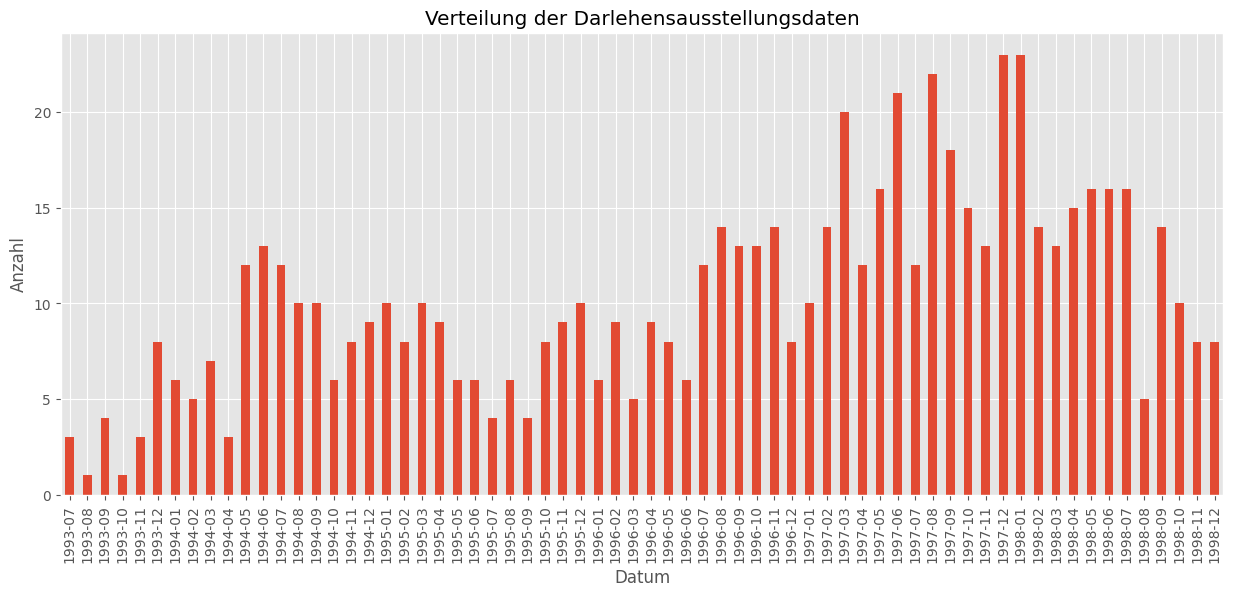

In [57]:
# plot distribution of date
plt.figure(figsize=(15, 6))
loan["date"].dt.to_period("M").value_counts().sort_index().plot(kind="bar")
plt.title("Verteilung der Darlehensausstellungsdaten")
plt.xlabel("Datum")
plt.ylabel("Anzahl")
plt.show()

### Dauer
Hier ersichtlich ist die Verteilung der Dauer der Darlehen. Sie ist fast gleichverteilt über die 5 möglichen Optionen. 

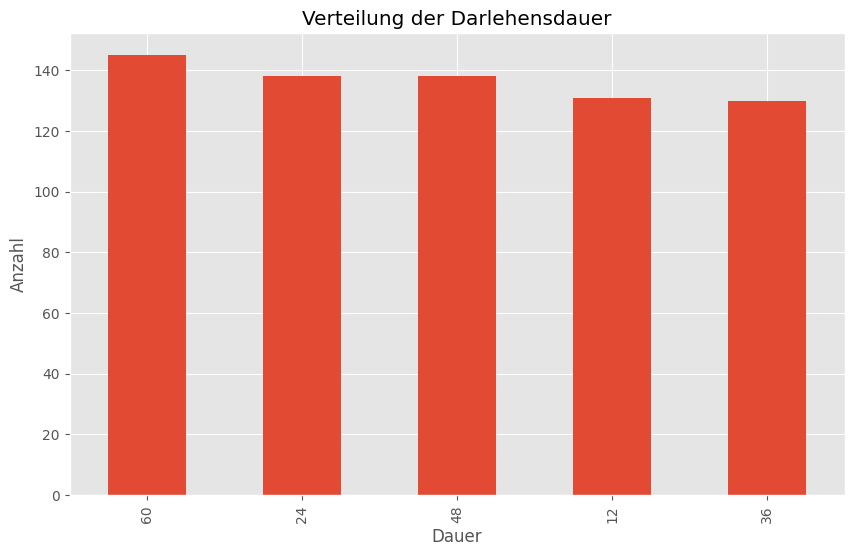

In [58]:
# plot duration distribution
plt.figure(figsize=(10, 6))
loan["duration"].value_counts().plot(kind="bar")
plt.title("Verteilung der Darlehensdauer")
plt.xlabel("Dauer")
plt.ylabel("Anzahl")
plt.show()

### Betrag
Hier dargestellt ist die Verteilung der Darlehensbeträge. Nur wenige Darlehensbeträge sind höher als 400000 wobei die meisten um die 100000 betragen. 

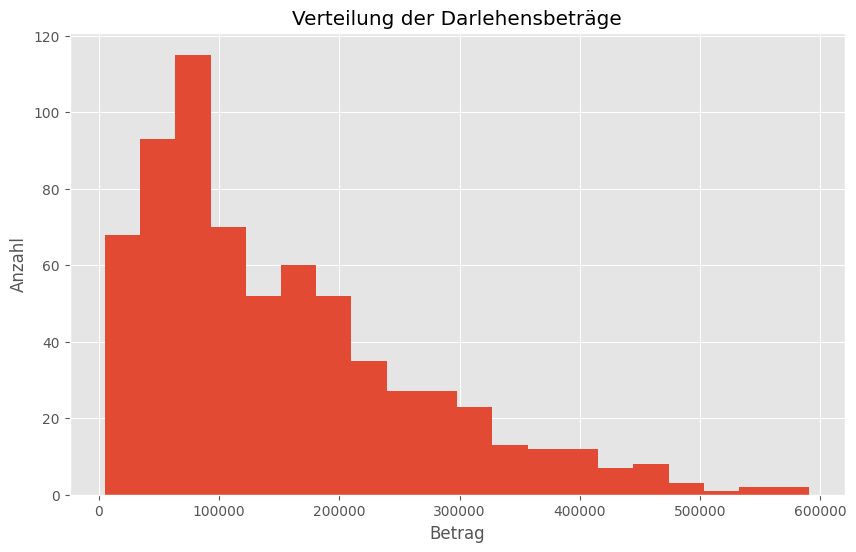

In [59]:
# plot amount
plt.figure(figsize=(10, 6))
loan["amount"].plot(kind="hist", bins=20)
plt.title("Verteilung der Darlehensbeträge")
plt.xlabel("Betrag")
plt.ylabel("Anzahl")
plt.show()

### Status
Der nachfolgende Plot zeigt die Klassenverteilung vom Darlehensstatus. Die meisten (~400) sind laufend und ok, rund 200 sind abgeschlossen, die Kunden von ~50 Darlehen sind verschuldet und etwas weniger wurden abgeschlossen, ohne fertig abbezahlt worden zu sein.  

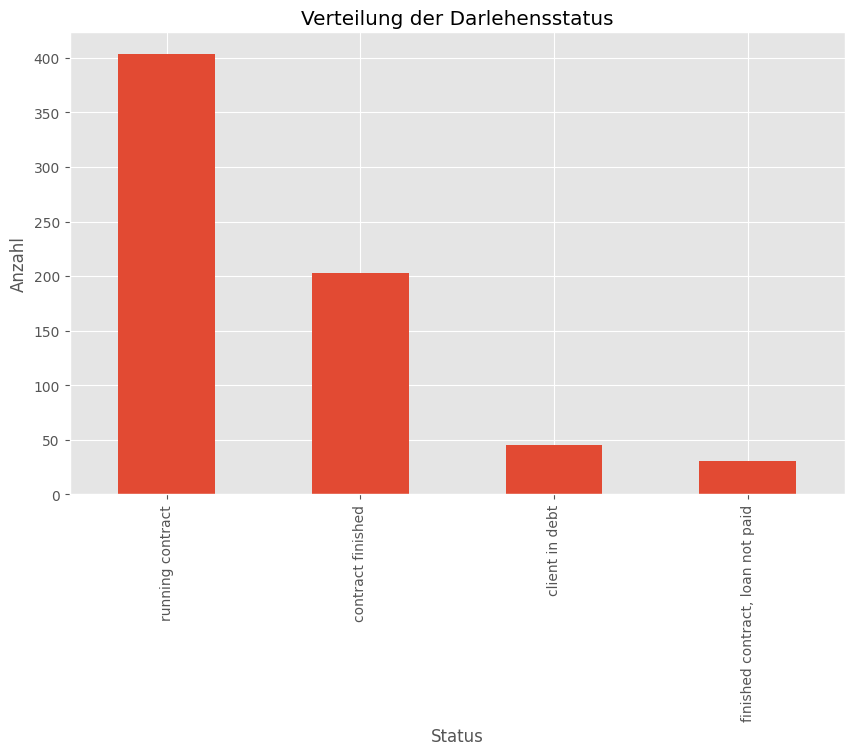

In [60]:
# plot status distribution
plt.figure(figsize=(10, 6))
loan["status"].value_counts().plot(kind="bar")
plt.title("Verteilung der Darlehensstatus")
plt.xlabel("Status")
plt.ylabel("Anzahl")
plt.show()

### Zahlungen
Hier ersichtlich ist die Verteilung der monatlichen Zahlungen der Darlehen. Die kleinste monatliche Zahlung beträgt 304 und die höchste 9910.

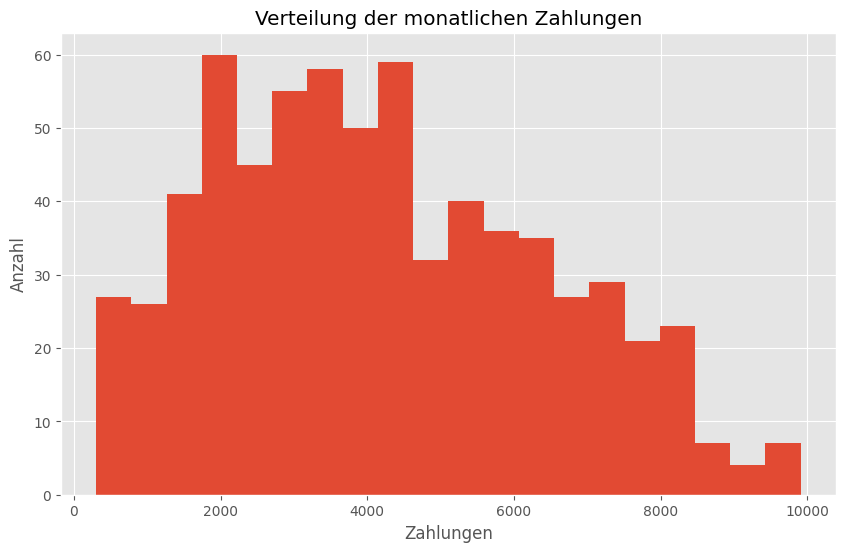

In [61]:
# plot payments
plt.figure(figsize=(10, 6))
loan["payments"].plot(kind="hist", bins=20)
plt.title("Verteilung der monatlichen Zahlungen")
plt.xlabel("Zahlungen")
plt.ylabel("Anzahl")
plt.show()

### Korrelation & weitere Informationen
Die Korrelation sowie weitere Informationen zu den vorhandenen Daten können aus dem [SweetViz Report](./reports/loan.html) entnommen werden.

In [62]:
# Assign the resulting DataFrame to a dictionary for storage
data_frames["loan.csv"] = loan

In [63]:
# %%capture
# svReport_loan = sv.analyze(loan)
# svReport_loan.show_html(filepath="./reports/loan.html", open_browser=False)

## Order
[//]: # (-.- .tabset)

Der Datensatz `order.csv` beinhaltet 6471 Observationen mit den folgenden Informationen über die Daueraufträge eines Kontos:  
- `order_id`: die Nummer des Dauerauftrags,
- `account_id`: die Kontonummer von welchem der Auftrag stammt,
- `bank_to`: die empfangende Bank,
- `account_to`: das empfangende Konto, 
- `amount`: der Betrag,
- `k_symbol`: die Art des Auftrags (Versicherungszahlung, Haushalt, Leasing, Darlehen)


In [64]:
order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6471 entries, 0 to 6470
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   order_id    6471 non-null   int64  
 1   account_id  6471 non-null   int64  
 2   bank_to     6471 non-null   object 
 3   account_to  6471 non-null   int64  
 4   amount      6471 non-null   float64
 5   k_symbol    6471 non-null   object 
dtypes: float64(1), int64(3), object(2)
memory usage: 303.5+ KB


In [65]:
print("Anzahl fehlender Werte:", sum(order.isnull().sum()))
print("Anzahl duplizierter Einträge:", order.duplicated().sum())

Anzahl fehlender Werte: 0
Anzahl duplizierter Einträge: 0


### Aufbereitung
Auch für `order.csv` werden die Kategorien zunächst übersetzt und fehlende Werte mit der Kategorie `unknown` ersetzt. Es bestehen deutlich mehr Daueraufträge als Bankkontos, was darauf hindeutet, dass ein Bankkonto mehrere Daueraufträge eingerichtet haben kann. Zur weiteren Verarbeitung der Daten wird das Format so geändert, dass pro Konto ein `order`-Eintrag existiert.  

In [66]:
# Kategorien übersetzen und fehlende Werte mit "unknown" füllen
order["k_symbol"] = (
    order["k_symbol"]
    .map(
        {
            "POJISTNE": "insurance_payment",
            "SIPO": "household",
            "UVER": "loan_payment",
            "LEASING": "leasing",
        }
    )
    .fillna("unknown")
)

order["k_symbol"] = order["k_symbol"].astype("category")

In [67]:
# Merge with 'account_id_df' to ensure all accounts are represented
order = pd.merge(account[["account_id"]], order, on="account_id", how="left")

# After merging, fill missing values that may have been introduced
order["k_symbol"] = order["k_symbol"].fillna("unknown")
order["amount"] = order["amount"].fillna(0)
order["has_order"] = ~order.isna().any(axis=1)

orders_pivot = order.pivot_table(
    index="account_id",
    columns="k_symbol",
    values="amount",
    aggfunc="sum",
    observed=False,
)

# Add prefix to column names
orders_pivot.columns = orders_pivot.columns

orders_pivot = orders_pivot.reset_index()

# NaN to 0
orders_pivot = orders_pivot.fillna(0)
# Sample 5 random rows from the merged DataFrame
orders_pivot.sample(n=5)

k_symbol  account_id  household  insurance_payment  leasing  loan_payment  \
1455            1534     7451.0                0.0      0.0           0.0   
2440            2566        0.0                0.0      0.0           0.0   
2490            2616     8188.0                0.0      0.0           0.0   
3917            4414     3716.0                0.0      0.0        4051.0   
740              779        0.0                0.0      0.0           0.0   

k_symbol  unknown  
1455       2155.0  
2440          0.0  
2490          0.0  
3917       3509.0  
740           0.0

### Empfangende Bank
Die Verteilung der empfangenden Banken ist ziemlich ausgeglichen, wobei in 742 Observationen diese Angabe fehlt.  

### Empfangendes Konto
Auch bei den empfangenden Konten scheint es keine auffällige Konzentration bei wenigen Konten zu geben und bei 742 Observationen fehlt die Angabe ebenfalls.  

### Betrag
Der Betrag bewegt sich im Bereich zwischen 0 - 14882 mit einem Mittelwert von 2943 und einem Median von 2249. Die Verteilung ist also stark rechtsschief

### Art
Die meisten Daueraufträge sind betreffend dem Haushalt eingerichtet worden (3502), die wenigsten für Leasing (341).  

### Korrelation & weitere Informationen
Die Korrelation sowie weitere Informationen zu den vorhandenen Daten können aus dem [SweetViz Report](./reports/order.html) entnommen werden.

In [68]:
# Assuming data_frames is a dictionary for storing DataFrames
data_frames["order.csv"] = orders_pivot

In [69]:
# %%capture
# svReport_order = sv.analyze(order)
# svReport_order.show_html(filepath="./reports/order.html", open_browser=False)

## Trans
[//]: # (-.- .tabset)

Der Datensatz `trans.csv` beinhaltet 1056320 Observationen mit den folgenden Informationen über die Transaktionen eines Kontos:  
- `trans_id`: die ID der Transaktion,
- `account_id`: die Kontonummer des ausführenden Kontos,
- `date`: das Datum,
- `type`: der Typ (Einzahlung, Bezug)
- `operation`: die Art der Transaktion (Bezug Kreditkarte, Bareinzahlung, Bezug über eine andere Bank, Bezug Bar, Überweisung)
- `amount`: der Betrag der Transaktion,
- `balance`: der Kontostand nach ausführung der Transaktion,
- `k_symbol`: die Klassifikation der Transaktion (Versicherungszahlung, Kontoauszug, Zinsauszahlung, Zinszahlung bei negativem Kontostand, Haushalt, Pension, Darlehensauszahlung),
- `bank`: die empfangende Bank und 
- `account`: das empfangende Bankkonto


In [70]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056320 entries, 0 to 1056319
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   trans_id    1056320 non-null  int64  
 1   account_id  1056320 non-null  int64  
 2   date        1056320 non-null  object 
 3   type        1056320 non-null  object 
 4   operation   873206 non-null   object 
 5   amount      1056320 non-null  float64
 6   balance     1056320 non-null  float64
 7   k_symbol    574439 non-null   object 
 8   bank        273508 non-null   object 
 9   account     295389 non-null   float64
dtypes: float64(3), int64(2), object(5)
memory usage: 80.6+ MB


In [71]:
print("Anzahl fehlender Werte:", sum(trans.isnull().sum()))
print("Anzahl duplizierter Einträge:", trans.duplicated().sum())

Anzahl fehlender Werte: 2208738
Anzahl duplizierter Einträge: 0


### Aufbereitung
Die Kategorien für `type`, `operation` und `k_symbol` wurden übersetzt und die Datentypen korrigiert.  

In [72]:
trans["date"] = pd.to_datetime(trans["date"], format="%y%m%d")

# Update 'type' column
trans["type"] = trans["type"].replace(
    {"PRIJEM": "credit", "VYDAJ": "withdrawal", "VYBER": "withdrawal"}
)
trans["type"] = trans["type"].astype("category")

# Update 'operation' column
trans["operation"] = trans["operation"].replace(
    {
        "VYBER KARTOU": "credit card withdrawal",
        "VKLAD": "credit in cash",
        "PREVOD Z UCTU": "collection from another bank",
        "VYBER": "cash withdrawal",
        "PREVOD NA UCET": "remittance to another bank",
    }
)
trans["operation"] = trans["operation"].astype("category")

# Update 'k_symbol' column
trans["k_symbol"] = trans["k_symbol"].replace(
    {
        "POJISTNE": "insurance payment",
        "SLUZBY": "statement payment",
        "UROK": "interest credited",
        "SANKC. UROK": "sanction interest if negative balance",
        "SIPO": "household payment",
        "DUCHOD": "pension credited",
        "UVER": "loan payment",
    }
)
trans["k_symbol"] = trans["k_symbol"].astype("category")

# negate the amount if type is credit
trans.loc[trans["type"] == "withdrawal", "amount"] = trans.loc[
    trans["type"] == "withdrawal", "amount"
] * (-1)

In [73]:
# Sample 5 random rows from the DataFrame
trans.sample(n=5)

trans_id  account_id       date        type  \
815085    339044        1150 1998-03-21  withdrawal   
418391    430080        1461 1996-11-14      credit   
940945   2575727        8505 1998-08-12  withdrawal   
584023   2454791        8094 1997-06-30  withdrawal   
80065    1113554        3804 1994-08-09  withdrawal   

                           operation   amount  balance           k_symbol  \
815085               cash withdrawal   -300.0  12740.3                NaN   
418391  collection from another bank  42171.0  86054.2                NaN   
940945               cash withdrawal -16300.0  34536.5                NaN   
584023               cash withdrawal    -14.6  52521.8  statement payment   
80065     remittance to another bank   -643.0  85524.2  household payment   

       bank     account  
815085  NaN         NaN  
418391   CD  43851268.0  
940945  NaN         NaN  
584023  NaN         NaN  
80065    WX  32746297.0

### Zeitliche Entwicklung eines Kontos

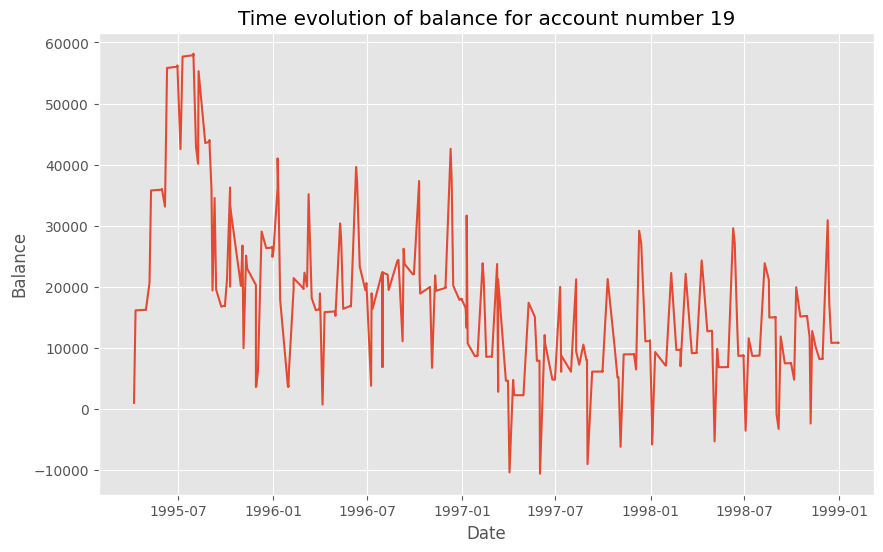

In [74]:
# Plot Zeitliche Entwicklung des Konto-Saldos für die Konto nummer 19
account_19 = trans[trans["account_id"] == 19].copy()  # Create a copy of the DataFrame
# Ensure the date column is in datetime format
account_19["date"] = pd.to_datetime(account_19["date"])

# Sort the values by date
account_19 = account_19.sort_values("date")

plt.figure(figsize=(10, 6))
plt.plot(account_19["date"], account_19["balance"])
plt.title("Time evolution of balance for account number 19")
plt.xlabel("Date")
plt.ylabel("Balance")
plt.show()

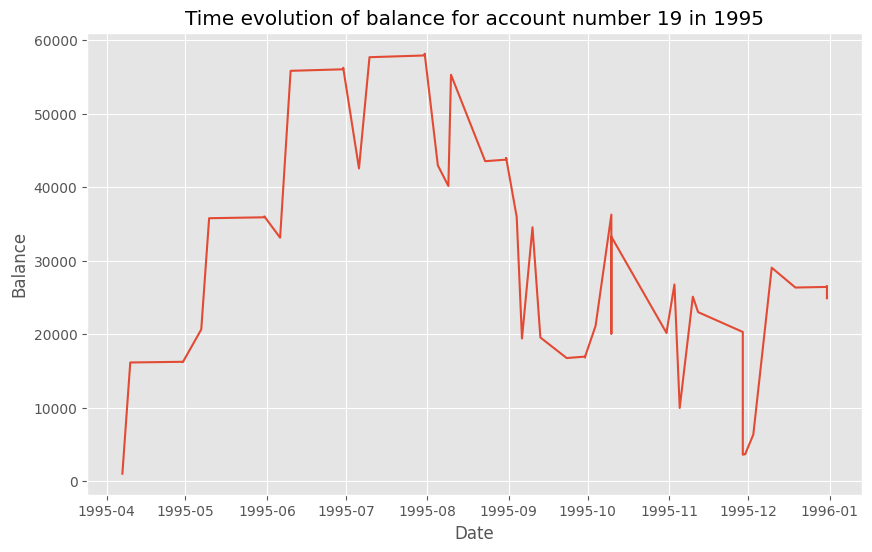

In [75]:
# zoom the year 1995 of the plot
account_19_1995 = account_19[account_19["date"].dt.year == 1995]
# plot it
plt.figure(figsize=(10, 6))
plt.plot(account_19_1995["date"], account_19_1995["balance"])
plt.title("Time evolution of balance for account number 19 in 1995")
plt.xlabel("Date")
plt.ylabel("Balance")
plt.show()

# Wee see that there is a steep line in 1995-10 so there are two transactions, this we have to clean.

### Korrelation & weitere Informationen
Die Korrelation sowie weitere Informationen zu den vorhandenen Daten können aus dem [SweetViz Report](./reports/trans.html) entnommen werden.

In [76]:
# Assign to a dictionary if needed (similar to list assignment in R)
data_frames["trans.csv"] = trans

In [77]:
# %%capture
# svReport_trans = sv.analyze(trans)
# svReport_trans.show_html(filepath="./reports/trans.html", open_browser=False)

# Kombinieren der Daten zu einem Modellierungsdatensatz
Im nachfolgenden Abschnitt werden die Daten zu statischen (Kunden-) Daten und transaktionellen (Bankdienstleistungs-) Daten kombiniert um diese anschliessend zu einem Datensatz für die Modellierung zusammenzufügen.  
 
## Stammdaten
Die aufbereiteten Stammdaten aus den Dateien 
- `disp.csv`
- `account.csv`
- `client.csv`
- `card.csv`
- `loan.csv` 
- `order.csv`
- `districts.csv`

werden nachfolgend zu einem Datensatz kombiniert. 

In [78]:
# merge dataframes
static_data = (
    data_frames["disp.csv"]
    .merge(data_frames["account.csv"], on="account_id", validate="1:1", how="left")
    .merge(
        data_frames["client.csv"],
        on="client_id",
        validate="1:1",
        suffixes=("_account", "_client"),
        how="left",
    )
    .merge(
        data_frames["card.csv"],
        on="disp_id",
        validate="1:1",
        suffixes=("_disp", "_card"),
        how="left",
    )
    .merge(
        data_frames["loan.csv"],
        on="account_id",
        suffixes=("_account", "_loan"),
        validate="1:1",
        how="left",
    )
    .merge(data_frames["order.csv"], on="account_id", validate="1:1", how="left")
    .merge(
        data_frames["district.csv"].add_suffix("_account"),
        left_on="district_id_account",
        right_on="district_id_account",
        validate="m:1",
        how="left",
    )
    .merge(
        data_frames["district.csv"].add_suffix("_client"),
        left_on="district_id_client",
        right_on="district_id_client",
        validate="m:1",
        how="left",
    )
)

In [79]:
static_data["has_card"] = ~static_data["card_id"].isna()

In [80]:
static_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 56 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   disp_id                                 4500 non-null   int64         
 1   client_id                               4500 non-null   int64         
 2   account_id                              4500 non-null   int64         
 3   type_disp                               4500 non-null   category      
 4   district_id_account                     4500 non-null   int64         
 5   frequency                               4500 non-null   category      
 6   date_account                            4500 non-null   datetime64[ns]
 7   district_id_client                      4500 non-null   int64         
 8   gender                                  4500 non-null   category      
 9   birth_day                               4500 non-nul

In [81]:
print("Anzahl duplizierter Einträge:", static_data.duplicated().sum())

Anzahl duplizierter Einträge: 0


In [82]:
## Junior Cards removal
# In the advertising campaign, we do not want to promote children's/junior cards (for whatever reasons). First, I looked at the distribution of age at issuance. Here I see that there are not many junior cards, nor are the cards issued at a late age.
# # Filter rows where 'card_type' contains 'junior' (case insensitive)
# junior_cards = static_data[
#     static_data["type_card"].str.contains("junior", case=False, na=False)
# ]
#
# display(junior_cards)
#
# # Calculate age at issue
# junior_cards["age_at_issue"] = (
#                                        junior_cards["issued_card"] - junior_cards["birth_day_client"]
#                                ).dt.days // 365
#
# # Plot histogram
# plt.figure(figsize=(10, 6))
# sns.histplot(data=junior_cards, x="age_at_issue", bins=20)
# plt.title("Age distribution at issue date of junior cards")
# plt.xlabel("Age at issue date")
# plt.ylabel("Number of cards")
# plt.show()

## Junior Cards Removal

In [83]:
num_accounts_before = len(static_data)
# # Filter rows where 'card_type' does not contain 'junior' (case insensitive)
static_data = static_data[
    ~static_data["type_card"].str.contains("junior", case=False, na=False)
]
num_accounts_after = len(static_data)
num_junior_cards = num_accounts_before - num_accounts_after
print(f"Number of junior cards removed: {num_junior_cards}")

Number of junior cards removed: 145


## Bewegungsdaten
### Käufer


In [84]:
# select all transactions from trans from date 1995-03-16 and account_id 150
trans[(trans["date"] == "1995-03-16") & (trans["account_id"] == 150)]

trans_id  account_id       date    type       operation  amount  \
148637     44703         150 1995-03-16  credit  credit in cash   900.0   
148638     44714         150 1995-03-16  credit  credit in cash  1900.0   

        balance k_symbol bank  account  
148637   2800.0      NaN  NaN      NaN  
148638   1900.0      NaN  NaN      NaN

In [85]:
# sort dataframe trans by account_id and date
first_row_per_account = trans.groupby("account_id")

# select rows where amount == balance
first_row_per_account = first_row_per_account.apply(
    lambda x: x[x["amount"] == x["balance"]].iloc[0], include_groups=False
).reset_index()

In [86]:
# show that there's one row per unique account_id in trans
first_row_per_account["account_id"].nunique() == trans["account_id"].nunique()

True

In [87]:
first_row_per_account.query("amount != balance")

Empty DataFrame
Columns: [account_id, trans_id, date, type, operation, amount, balance, k_symbol, bank, account]
Index: []

In [88]:
# Extract year and month from date to a new column 'year_month'
trans["year_month"] = trans["date"].dt.to_period("M")

# Group by 'account_id' and 'month', and calculate the sum of 'amount', 'credit', 'withdrawal' and 'n_transactions'
transactions_monthly = (
    trans.groupby(["account_id", "year_month"])
    .agg(
        volume=("amount", "sum"),
        credit=("amount", lambda x: x[x > 0].sum()),
        withdrawal=("amount", lambda x: x[x < 0].sum()),
        n_transactions=("amount", "count"),
    )
    .reset_index()
)

# # Fill missing months for each account
# transactions_monthly = transactions_monthly.set_index(['year_month', 'account_id']).unstack(
#     fill_value=0).stack(future_stack=True).reset_index()

# Calculate cumulative sum of 'volume' for each account
transactions_monthly["balance"] = transactions_monthly.groupby("account_id")[
    "volume"
].cumsum()

In [89]:
def rollup_credit_card(trans_monthly, account_card_issue_dates):
    # Add issue date and calculate months since card issue
    trans_monthly = pd.merge(trans_monthly, account_card_issue_dates, on="account_id")

    trans_monthly["months_before_card_issue"] = [
        (issued - year_month).n
        for issued, year_month in zip(
            trans_monthly["issued"], trans_monthly["year_month"]
        )
    ]

    # select only where  months_before_card_issue >0 and <= 13
    trans_monthly = trans_monthly[
        (trans_monthly["months_before_card_issue"] > 0)
        & (trans_monthly["months_before_card_issue"] <= 13)
    ]

    trans_monthly = trans_monthly.groupby("account_id").filter(lambda x: len(x) == 13)

    # Pivot wider
    trans_monthly = trans_monthly.pivot_table(
        index="account_id",
        columns="months_before_card_issue",
        values=["volume", "credit", "withdrawal", "n_transactions", "balance"],
    )
    trans_monthly.reset_index(inplace=True)
    trans_monthly.columns = [
        "_".join(str(i) for i in col) for col in trans_monthly.columns
    ]
    # rename account_id_ to account_id
    trans_monthly = trans_monthly.rename(columns={"account_id_": "account_id"})

    return trans_monthly

In [90]:
buyers = static_data[static_data["has_card"]]

transactions_rolled_up_buyers = rollup_credit_card(
    transactions_monthly, buyers.loc[:, ["account_id", "issued"]]
)

### Nicht-Käufer


In [91]:
# model top-n similarity of districts
def calculate_district_similarity():
    data = data_frames["district.csv"]
    data = data.drop(columns=["region", "district_name"])

    # Calculate the similarity matrix
    similarity_matrix = cosine_similarity(data)

    # Create a DataFrame from the similarity matrix
    similarity_df = pd.DataFrame(
        similarity_matrix, index=data.index, columns=data.index
    )

    # Create a mask to exclude the diagonal
    mask = np.eye(len(similarity_df), dtype=bool)

    # Apply the mask to the DataFrame
    similarity_df = similarity_df.mask(mask)

    return similarity_df

In [92]:
def top_n_similarity(district_id, n, similarity_df):
    # Get the row of the similarity matrix corresponding to the district_id
    similarity_row = similarity_df.loc[district_id - 1]

    # Sort the values in the row in descending order and get the top n indices
    top_n_indices = similarity_row.sort_values(ascending=False).head(n).index

    # append district id to top_n_indices
    top_n_indices = top_n_indices.append(pd.Index([district_id]))

    return top_n_indices

In [93]:
# find similar non-buyers
def find_similar_non_buyers(buyers, non_buyers):
    similar_non_buyers = pd.DataFrame(
        columns=["account_id", "issued"]
    )  # TODO better way? right now warning?!
    no_similar_found = []
    district_similarities = calculate_district_similarity()

    for _, buyer in buyers.iterrows():
        # exclude already found similar_non_buyers from non_buyer's list
        non_buyers = non_buyers[
            ~non_buyers["account_id"].isin(similar_non_buyers["account_id"])
        ]
        # find top n similar districts
        top_n_similar = top_n_similarity(
            buyer["district_id_client"], 2, district_similarities
        )

        # Find non-buyers with similar age, sex, and district
        similar = non_buyers[
            (non_buyers["age"] >= buyer["age"] - 3)
            & (non_buyers["age"] <= buyer["age"] + 3)
            & (non_buyers["gender"] == buyer["gender"])
            & (non_buyers["district_id_account"].isin(top_n_similar))
        ]

        # join transaction data to similar
        similar = pd.merge(similar, transactions_monthly, on="account_id")

        similar["issued"] = buyer["issued"]
        similar["months_before_card_issue"] = [
            (issued - year_month).n
            for issued, year_month in zip(similar["issued"], similar["year_month"])
        ]

        # select only where months_before_card_issue > 0 and <= 13
        similar = similar[
            (similar["months_before_card_issue"] > 0)
            & (similar["months_before_card_issue"] <= 13)
        ]

        # make sure there's 13 rows per account_id and drop account_ids for which that's not true
        similar = similar.groupby("account_id").filter(lambda x: len(x) == 13)

        # next if similar is empty
        if similar.empty:
            no_similar_found.append(buyer["account_id"])
            continue

        # drop duplicates
        similar = similar.drop_duplicates(subset=["account_id"])

        # Append similar similar['account_id'] and similar['nb_issued'] to similar_non_buyers
        similar_non_buyers = pd.concat(
            [similar_non_buyers, similar[["account_id", "issued"]]]
        )

    return similar_non_buyers, no_similar_found

In [94]:
non_buyers = static_data[~static_data["has_card"]]
similar_non_buyers, none_found = find_similar_non_buyers(buyers, non_buyers)

C:\Users\super\AppData\Local\Temp\ipykernel_67096\1600601699.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  similar_non_buyers = pd.concat(


In [95]:
len(non_buyers[~non_buyers["account_id"].isin(similar_non_buyers["account_id"])])

1594

In [96]:
transactions_rolled_up_non_buyers = rollup_credit_card(
    transactions_monthly, similar_non_buyers
)

## Zusammenfügen der Daten

In [97]:
transactions_rolled_up = pd.concat(
    [transactions_rolled_up_buyers, transactions_rolled_up_non_buyers]
)

In [98]:
# merge transactions_rolled_up and static data
X = pd.merge(static_data, transactions_rolled_up, on="account_id")

## Remove Data

In [99]:
# print underage accounts

## Visualize

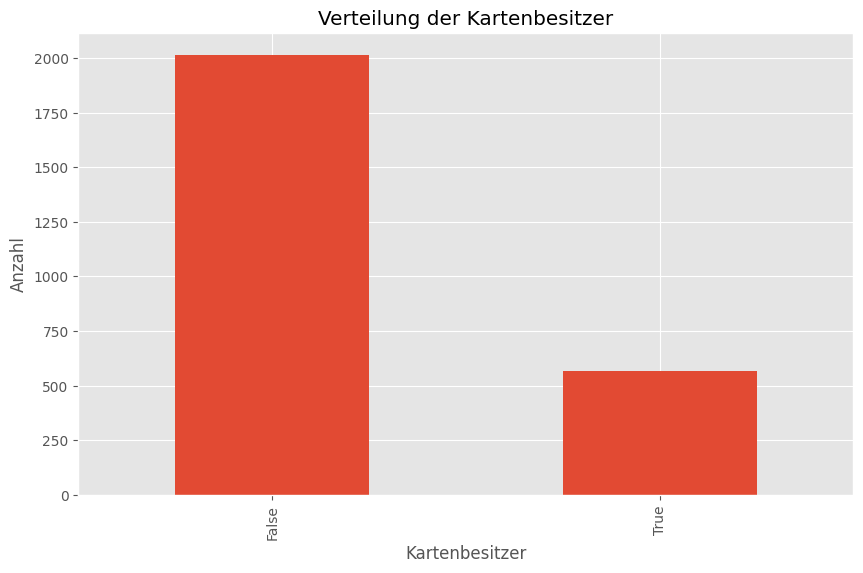

In [100]:
# plot distribution of has_card
plt.figure(figsize=(10, 6))
X["has_card"].value_counts().plot(kind="bar")
plt.title("Verteilung der Kartenbesitzer")
plt.xlabel("Kartenbesitzer")
plt.ylabel("Anzahl")
plt.show()

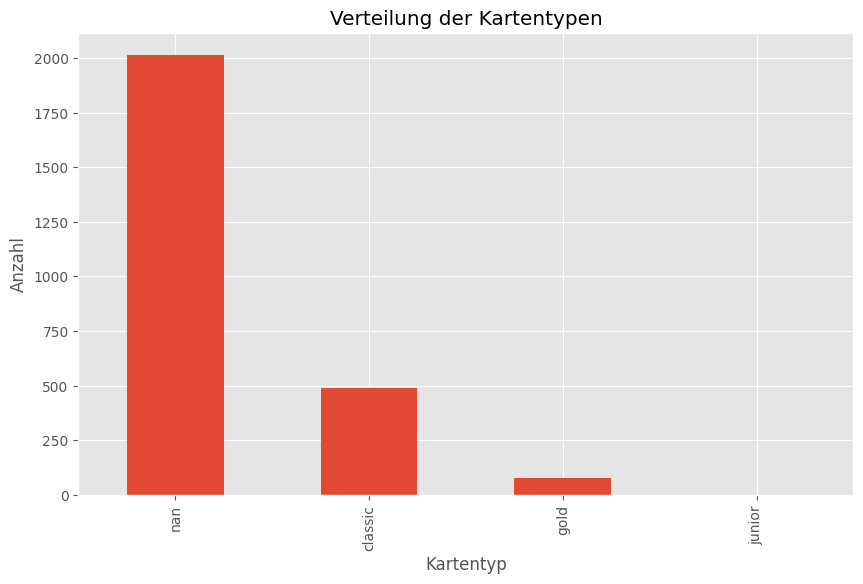

In [101]:
## plot distribution of card_type
plt.figure(figsize=(10, 6))
X["type_card"].value_counts(dropna=False).plot(kind="bar")
plt.title("Verteilung der Kartentypen")
plt.xlabel("Kartentyp")
plt.ylabel("Anzahl")
plt.show()

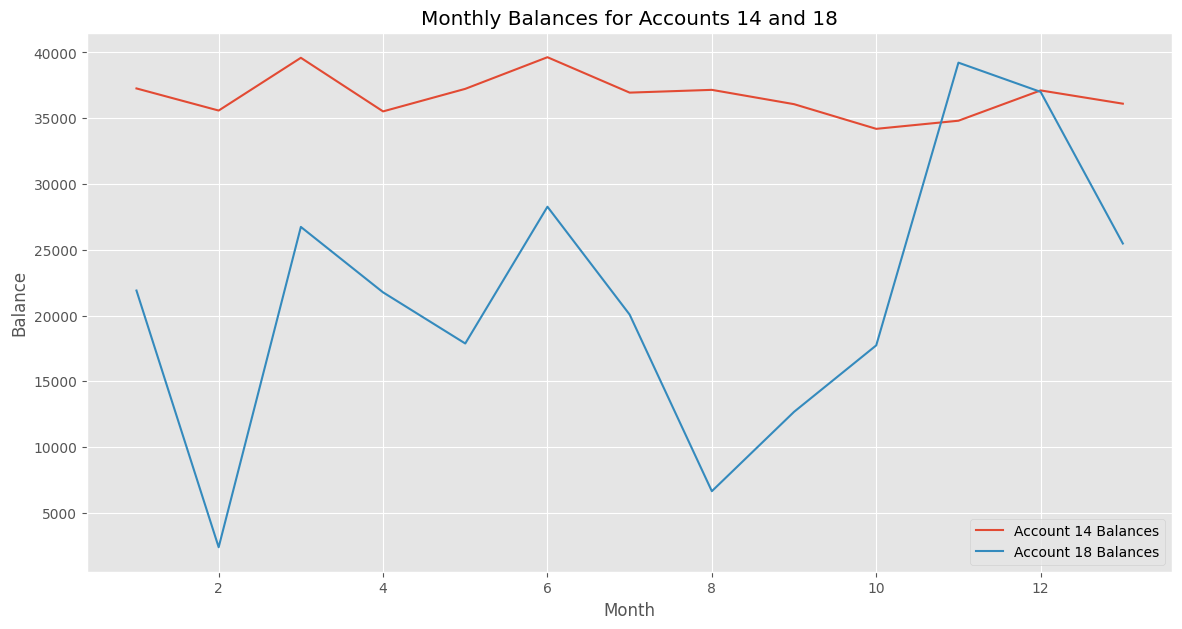

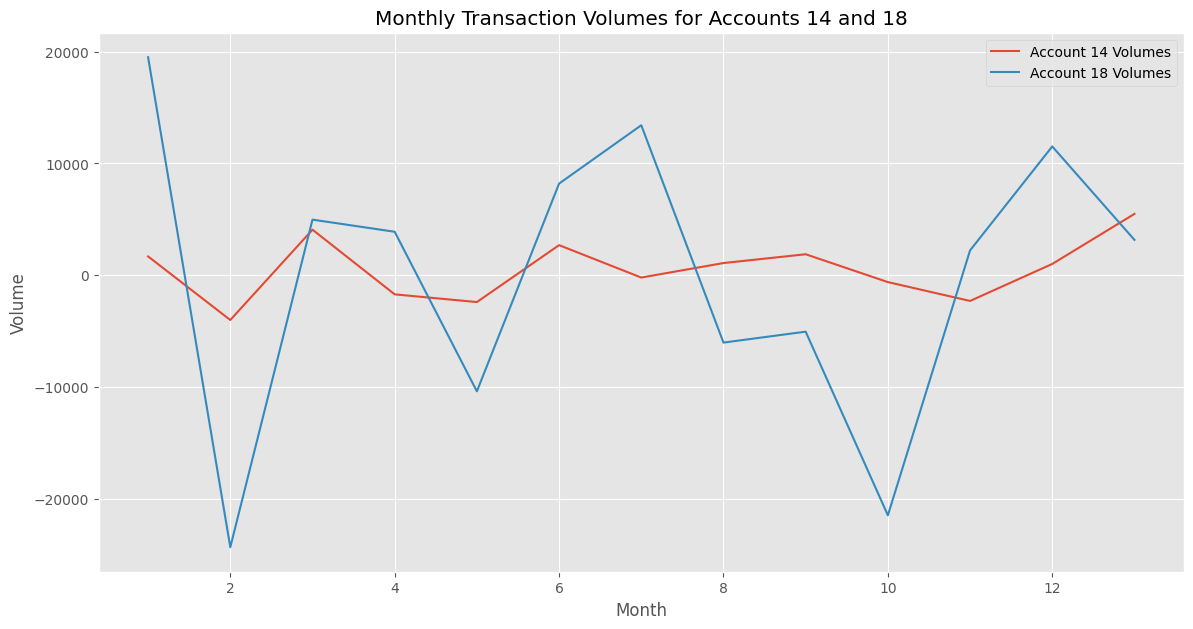

In [102]:
# Filter the data for accounts 14 and 18
account_data = X[X["account_id"].isin([14, 18])]
# Reshape the DataFrame for easier plotting
months = [f"Month {i}" for i in range(1, 14)]
balances = [f"balance_{i}" for i in range(1, 14)]
volumes = [f"volume_{i}" for i in range(1, 14)]

# Melt the DataFrame for balances and volumes
balance_data = account_data.melt(
    id_vars="account_id", value_vars=balances, var_name="Month", value_name="Balance"
)
volume_data = account_data.melt(
    id_vars="account_id", value_vars=volumes, var_name="Month", value_name="Volume"
)

# Convert 'Month' from string to integer for proper sorting
balance_data["Month"] = balance_data["Month"].str.extract("(\d+)").astype(int)
volume_data["Month"] = volume_data["Month"].str.extract("(\d+)").astype(int)

# Sort data by account and month
balance_data = balance_data.sort_values(by=["account_id", "Month"])
volume_data = volume_data.sort_values(by=["account_id", "Month"])
# Plotting balance data
plt.figure(figsize=(14, 7))
for key, grp in balance_data.groupby("account_id"):
    plt.plot(grp["Month"], grp["Balance"], label=f"Account {key} Balances")
plt.title("Monthly Balances for Accounts 14 and 18")
plt.xlabel("Month")
plt.ylabel("Balance")
plt.legend()
plt.show()

# Plotting volume data
plt.figure(figsize=(14, 7))
for key, grp in volume_data.groupby("account_id"):
    plt.plot(grp["Month"], grp["Volume"], label=f"Account {key} Volumes")
plt.title("Monthly Transaction Volumes for Accounts 14 and 18")
plt.xlabel("Month")
plt.ylabel("Volume")
plt.legend()
plt.show()

In [103]:
print(X.dtypes)

disp_id                                            int64
client_id                                          int64
account_id                                         int64
type_disp                                       category
district_id_account                                int64
frequency                                       category
date_account                              datetime64[ns]
district_id_client                                 int64
gender                                          category
birth_day                                 datetime64[ns]
age                                                int64
card_id                                          float64
type_card                                       category
issued                                         period[M]
loan_id                                          float64
date_loan                                 datetime64[ns]
amount                                           float64
duration                       

In [104]:
X.columns

Index(['disp_id', 'client_id', 'account_id', 'type_disp',
       'district_id_account', 'frequency', 'date_account',
       'district_id_client', 'gender', 'birth_day',
       ...
       'withdrawal_4', 'withdrawal_5', 'withdrawal_6', 'withdrawal_7',
       'withdrawal_8', 'withdrawal_9', 'withdrawal_10', 'withdrawal_11',
       'withdrawal_12', 'withdrawal_13'],
      dtype='object', length=121)

# Preprocessing

In [105]:
# Assuming 'X' is your DataFrame and 'has_card' is the target variable
y = X["has_card"]
XX = X.drop(columns=["has_card"])
selected_fields = (
    ["age", "gender", "region_client"]
    + [f"volume_{i}" for i in range(1, 14)]
    + [f"balance_{i}" for i in range(1, 14)]
)
XX = X[selected_fields]

# Define categorical and numeric columns
categorical_cols = XX.select_dtypes(include=["category", "object"]).columns
numeric_cols = XX.select_dtypes(include=["int64", "float64"]).columns

# Create transformers for numeric and categorical data
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),  # or mean, most_frequent
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# Combine transformers into a preprocessor with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

## Test-Train-Split

In [106]:
# At the time not used because We use KFolds for cross validation instead of Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(
    XX, y, test_size=0.2, random_state=42, stratify=y
)

## Drop Featrues

In [107]:
# Remove the Variable that can lead to data leakage
def clean_data(df):
    # Define unnecessary columns
    unnecessary_cols = [
        "disp_id",
        "client_id",
        "account_id",
        "type_card",
        "card_id",
        "loan_id",
        "district_id_account",
        "district_id_client",
    ]
    # Drop these columns if they exist in the dataframe
    df_cleaned = df.drop(columns=[col for col in unnecessary_cols if col in df.columns])
    return df_cleaned


X = clean_data(X)

In [108]:
print(X.columns)

Index(['type_disp', 'frequency', 'date_account', 'gender', 'birth_day', 'age',
       'issued', 'date_loan', 'amount', 'duration',
       ...
       'withdrawal_4', 'withdrawal_5', 'withdrawal_6', 'withdrawal_7',
       'withdrawal_8', 'withdrawal_9', 'withdrawal_10', 'withdrawal_11',
       'withdrawal_12', 'withdrawal_13'],
      dtype='object', length=113)


## Feature Engineering für Logistic Regression

In [109]:
df = X.copy()


# Function to calculate features
def calculate_features(df, prefix):
    monthly_values = df[[f"{prefix}_{i}" for i in range(1, 13)]]
    # needs to be a small constant to avoid division by zero
    epsilon = 1e-7  # small constant
    features = {
        f"{prefix}_mean": monthly_values.mean(axis=1),
        f"{prefix}_min": monthly_values.min(axis=1),
        f"{prefix}_max": monthly_values.max(axis=1),
        f"{prefix}_mad": monthly_values.sub(monthly_values.mean(axis=1), axis=0)
        .abs()
        .mean(axis=1),
        f"{prefix}_mean_ratio_last3_first3": (
            monthly_values[[f"{prefix}_{i}" for i in range(10, 13)]].mean(axis=1)
            / (
                monthly_values[[f"{prefix}_{i}" for i in range(1, 4)]].mean(axis=1)
                + epsilon
            )
        ),
    }

    if prefix in ["credit", "withdrawal"]:
        features[f"{prefix}_sum"] = monthly_values.sum(axis=1)
    if prefix in ["balance", "credit"]:
        features[f"{prefix}_std"] = monthly_values.std(axis=1)

    return features


# List of column prefixes for required calculations
columns_to_process = ["balance", "credit", "n_transactions", "withdrawal"]

# Generating features for each prefix and merging them
all_features = {}
for prefix in columns_to_process:
    all_features.update(calculate_features(df, prefix))

# Creating the final dataframe with new features
df_features = pd.DataFrame(all_features)


display(df_features.head(5))
X_feature_engineered = pd.concat([X, df_features], axis=1)
display(X_feature_engineered.head(5))

balance_mean  balance_min  balance_max  balance_mad  \
0  14303.958333      11252.7      16783.5  1681.458333   
1  44075.225000      29056.8      53875.0  6944.575000   
2  24875.958333      12394.6      31121.6  4308.048611   
3  65303.058333      50259.0      75577.3  6644.475000   
4  39687.808333      21998.2      48008.0  4808.223611   

   balance_mean_ratio_last3_first3  balance_std   credit_mean  credit_min  \
0                         0.907441  1944.400240   4106.125000      3728.6   
1                         1.144143  8348.802666  23204.033333     20375.4   
2                         0.984262  5836.859534   9527.916667      7580.7   
3                         0.785161  8185.479842  24834.325000     22902.7   
4                         0.744918  6989.669823  19644.325000     17784.8   

   credit_max   credit_mad  credit_mean_ratio_last3_first3  credit_sum  \
0      5437.3   549.404167                        0.882873     49273.5   
1     30607.9  3685.283333                        0.977140    278448.4   
2     15380.7  2197.388889                        1.109942    114335.0   
3     34296.9  3149.458333                        1.161736    298011.9   
4     27391.4  2675.854167                        0.895112    235731.9   

    credit_std  n_transactions_mean  n_transactions_min  n_transactions_max  \
0   671.415556             5.583333                 4.0                 9.0   
1  4482.817718             6.750000                 5.0                11.0   
2  2655.783571             6.500000                 3.0                13.0   
3  4413.427098             5.833333                 5.0                11.0   
4  3567.539450             5.000000                 3.0                 7.0   

   n_transactions_mad  n_transactions_mean_ratio_last3_first3  \
0            1.013889                                1.062500   
1            1.041667                                1.052632   
2            2.166667                                0.428571   
3            0.972222                                0.937500   
4            1.333333                                0.500000   

   withdrawal_mean  withdrawal_min  withdrawal_max  withdrawal_mad  \
0     -4274.100000         -7066.6         -2466.6     1347.500000   
1    -21446.016667        -43780.6         -9880.6     7709.652778   
2     -7644.950000        -21935.6             0.0     3930.433333   
3    -23037.933333        -34054.6        -13094.6     4293.333333   
4    -15868.983333        -30887.6             0.0     6078.516667   

   withdrawal_mean_ratio_last3_first3  withdrawal_sum  
0                            1.759650        -51289.2  
1                            0.872599       -257352.2  
2                            0.459332        -91739.4  
3                            1.094859       -276455.2  
4                            0.312591       -190427.8

type_disp frequency date_account  gender  birth_day  age   issued  \
0     OWNER   monthly   1995-03-24  female 1970-12-13   29      NaT   
1     OWNER   monthly   1993-02-26    male 1945-02-04   54      NaT   
2     OWNER   monthly   1997-07-07    male 1956-12-01   43      NaT   
3     OWNER   monthly   1996-11-24    male 1935-10-16   64  1998-10   
4     OWNER   monthly   1996-08-28  female 1974-05-29   25      NaT   

   date_loan   amount  duration  payments             status  household  \
0        NaT      NaN       NaN       NaN                NaN     2452.0   
1 1994-01-05  80952.0      24.0    3373.0  contract finished     7266.0   
2        NaT      NaN       NaN       NaN                NaN     1135.0   
3        NaT      NaN       NaN       NaN                NaN     4880.0   
4        NaT      NaN       NaN       NaN                NaN     7033.0   

   insurance_payment  leasing  loan_payment  unknown district_name_account  \
0                0.0      0.0           0.0      0.0                 Pisek   
1                0.0      0.0        3372.7      0.0           Hl.m. Praha   
2             3539.0      0.0           0.0    327.0                 Kolin   
3                0.0      0.0           0.0      0.0             Prostejov   
4                0.0   1344.0           0.0      0.0          Brno - mesto   

    region_account  num_of_habitat_account  num_of_small_town_account  \
0    south Bohemia                   70699                         60   
1           Prague                 1204953                          0   
2  central Bohemia                   95616                         65   
3    south Moravia                  110643                         49   
4    south Moravia                  387570                          0   

   num_of_medium_town_account  num_of_big_town_account  \
0                          13                        2   
1                           0                        0   
2                          30                        4   
3                          41                        4   
4                           0                        0   

   num_of_bigger_town_account  num_of_city_account  ratio_of_urban_account  \
0                           1                    4                    65.3   
1                           1                    1                   100.0   
2                           1                    6                    51.4   
3                           1                    4                    51.9   
4                           1                    1                   100.0   

   average_salary_account  unemploy_rate95_account  unemploy_rate96_account  \
0                    8968                     2.83                     3.35   
1                   12541                     0.29                     0.43   
2                    9307                     3.85                     4.43   
3                    8441                     3.45                     4.48   
4                    9897                     1.60                     1.96   

   n_of_enterpren_per1000_inhabit_account  no_of_crimes95_account  \
0                                     131                  1740.0   
1                                     167                 85677.0   
2                                     118                  2616.0   
3                                     115                  1879.0   
4                                     140                 18721.0   

   no_of_crimes96_account district_name_client    region_client  \
0                    1910                Pisek    south Bohemia   
1                   99107          Hl.m. Praha           Prague   
2                    3040                Kolin  central Bohemia   
3                    2252            Prostejov    south Moravia   
4                   18696         Brno - mesto    south Moravia   

   num_of_habitat_client  num_of_small_town_client  num_of_medium_town_client  \
0                  70699

# Models

In [110]:
class ModelEvaluator:
    def __init__(self, models, param_grid, X, y, selected_fields=None):
        """
        Initialize the evaluator with models, their parameter grids, and data.

        :param models: dict of (name, model) pairs
        :param param_grid: dict of (name, param_grid) pairs for GridSearch
        :param X: Feature matrix
        :param y: Target vector
        :param selected_fields: Fields selected for training
        """
        self.benchmark_results = {}
        self.models = models
        self.param_grid = param_grid
        self.X = X[selected_fields]
        self.y = y
        self.fitted_models = {}
        self.best_models = {}
        self.cv_predictions = {}

    def get_benchmark_results(self):
        return self.benchmark_results

    def fit_models(self):
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        for name, model in self.models.items():
            pipeline = self.create_pipeline(model)
            metrics = {
                "ROC AUC": "roc_auc",
                "Precision": "precision",
                "Recall": "recall",
                "Accuracy": "accuracy",
                "F-measure": make_scorer(fbeta_score, beta=1),
                "Kappa": make_scorer(cohen_kappa_score),
                "MCC": make_scorer(matthews_corrcoef),
            }
            self.benchmark_results[name] = {}
            all_cv_preds = np.zeros(len(self.y))
            for metric_name, metric in metrics.items():
                score = cross_val_score(
                    pipeline, self.X, self.y, cv=cv, scoring=metric, n_jobs=-1
                )
                self.benchmark_results[name][metric_name] = np.mean(score)
                print(f"{name}: {metric_name} = {np.mean(score):.2f}")
            for train_idx, test_idx in cv.split(self.X, self.y):
                pipeline.fit(self.X.iloc[train_idx], self.y.iloc[train_idx])
                all_cv_preds[test_idx] = pipeline.predict_proba(self.X.iloc[test_idx])[
                    :, 1
                ]
            self.cv_predictions[name] = all_cv_preds
            self.fitted_models[name] = pipeline.fit(self.X, self.y)

    def evaluate_models(self):
        if not self.fitted_models:
            self.fit_models()
        return self.benchmark_results

    def plot_roc_curves(self):
        if not self.fitted_models:
            self.fit_models()

        plt.figure(figsize=(10, 8))
        for name in self.fitted_models:
            y_scores = self.cv_predictions[name]
            fpr, tpr, _ = roc_curve(self.y, y_scores)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{name} (area = {roc_auc:.2f})")

        plt.plot([0, 1], [0, 1], "k--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curves")
        plt.legend(loc="lower right")
        plt.show()

    def create_pipeline(self, model):
        categorical_cols = self.X.select_dtypes(include=["category", "object"]).columns
        numeric_cols = self.X.select_dtypes(include=["int64", "float64"]).columns

        numeric_transformer = Pipeline(
            [
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler()),
            ]
        )

        categorical_transformer = Pipeline(
            [
                ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
                ("onehot", OneHotEncoder(handle_unknown="ignore")),
            ]
        )

        preprocessor = ColumnTransformer(
            [
                ("num", numeric_transformer, numeric_cols),
                ("cat", categorical_transformer, categorical_cols),
            ]
        )

        return Pipeline([("preprocessor", preprocessor), ("model", model)])

    def optimize_model(self, model_name):
        if model_name in self.best_models:
            return self.best_models[model_name]

        model = self.models[model_name]
        pipeline = self.create_pipeline(model)
        grid_search = GridSearchCV(
            pipeline, self.param_grid[model_name], cv=5, scoring="roc_auc"
        )
        grid_search.fit(self.X, self.y)
        print(f"Best parameters for {model_name}: {grid_search.best_params_}")
        self.best_models[model_name] = grid_search.best_estimator_
        return self.best_models[model_name]

    def compare_top_n_customers(self, model_name, n=100):
        if model_name in self.best_models:
            model = self.best_models[model_name]
        else:
            model = self.optimize_model(model_name)

        probabilities = model.predict_proba(self.X)[:, 1]
        top_n_indices = np.argsort(probabilities)[::-1][:n]

        plt.figure()
        plt.hist(probabilities[top_n_indices], bins=20, alpha=0.75)
        plt.title(f"Histogram of top {n} customers' probabilities")
        plt.xlabel("Probability")
        plt.ylabel("Frequency")
        plt.show()

    def explain_with_lime(self, model_name, num_features=10):
        if model_name in self.best_models:
            model = self.best_models[model_name]
        else:
            model = self.optimize_model(model_name)

        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        for train_idx, test_idx in cv.split(self.X, self.y):
            X_train, X_test = self.X.iloc[train_idx], self.X.iloc[test_idx]
            y_train, y_test = self.y.iloc[train_idx], self.y.iloc[test_idx]
            break  # Use the first fold

        # Ensure only numeric features are passed to LIME
        X_train_numeric = X_train.select_dtypes(include=[np.number])
        X_test_numeric = X_test.select_dtypes(include=[np.number])

        # Remove columns with zero variance
        X_train_numeric = X_train_numeric.loc[
            :, (X_train_numeric != X_train_numeric.iloc[0]).any()
        ]
        X_test_numeric = X_test_numeric.loc[:, X_train_numeric.columns]

        explainer = lime.lime_tabular.LimeTabularExplainer(
            X_train_numeric.values,
            feature_names=X_train_numeric.columns,
            class_names=["No Card", "Has Card"],
            discretize_continuous=True,
        )

        # Explain a prediction for a single instance
        idx = 0  # Index of the instance to explain
        exp = explainer.explain_instance(
            X_test_numeric.values[idx], model.predict_proba, num_features=num_features
        )
        exp.show_in_notebook(show_table=True, show_all=False)

    def explain_with_shap(self, model_name):
        if model_name in self.best_models:
            model = self.best_models[model_name]
        else:
            model = self.optimize_model(model_name)

        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        for train_idx, test_idx in cv.split(self.X, self.y):
            X_train, X_test = self.X.iloc[train_idx], self.X.iloc[test_idx]
            y_train, y_test = self.y.iloc[train_idx], self.y.iloc[test_idx]
            break  # Use the first fold

        # Ensure only numeric features are passed to SHAP
        X_train_numeric = X_train.select_dtypes(include=[np.number])
        X_test_numeric = X_test.select_dtypes(include=[np.number])

        explainer = shap.Explainer(model, X_train_numeric)
        shap_values = explainer(X_test_numeric)

        # Plot SHAP summary plot
        shap.summary_plot(shap_values, X_test_numeric)

        # Plot SHAP dependence plot for a single feature
        feature = "balance_mean"  # Feature to explain
        shap.dependence_plot(feature, shap_values, X_test_numeric)


class MetricsBenchmarker:
    def __init__(self):
        """
        Initialize the benchmarker with models and data.

        :param models: dict of (name, model) pairs
        :param X: Feature matrix
        :param y: Target vector
        :param selected_fields: Fields selected for training
        """
        self.benchmark_results = {}
        self.evals = []

    def add_evaluator(self, evaluator: ModelEvaluator):
        self.evals.append(evaluator)

    def set_benchmark_results(self):
        for eval in self.evals:
            self.benchmark_results.update(eval.get_benchmark_results())

    def display_benchmark_results_table(self):
        """
        Display a table of benchmark results.
        """
        results_df = pd.DataFrame(self.benchmark_results).T
        display(results_df)

    def plot_benchmark_results_bar_chart(self):
        """
        Plot a bar chart of benchmark results.
        """
        results_df = pd.DataFrame(self.benchmark_results).T
        results_df.plot(kind="bar", figsize=(10, 6))
        plt.title("Benchmark Results")
        plt.ylabel("Score")
        plt.show()


Baseline Logistic Regression: ROC AUC = 0.85
Baseline Logistic Regression: Precision = 0.51
Baseline Logistic Regression: Recall = 0.29
Baseline Logistic Regression: Accuracy = 0.78
Baseline Logistic Regression: F-measure = 0.37
Baseline Logistic Regression: Kappa = 0.25
Baseline Logistic Regression: MCC = 0.27


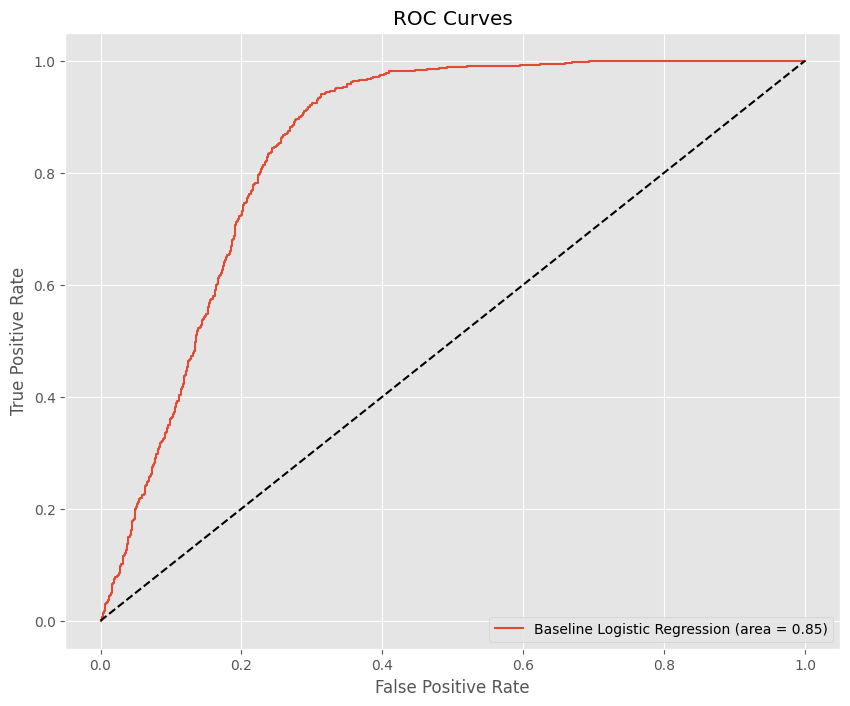

Best parameters for Baseline Logistic Regression: {'model__C': 0.01}


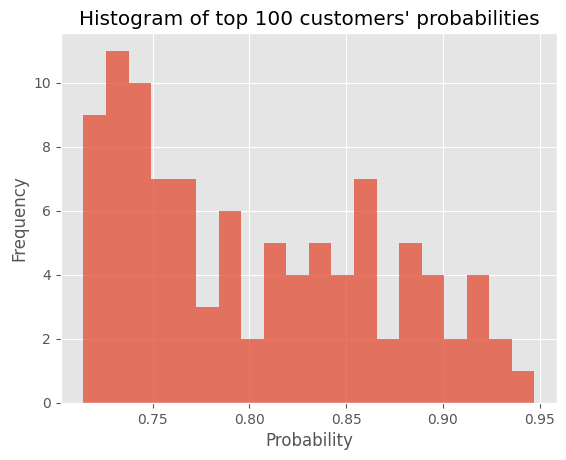

In [111]:
# Example usage
from sklearn.linear_model import LogisticRegression

# Define models and their parameter grids
models = {
    "Baseline Logistic Regression": LogisticRegression(solver="liblinear"),
}
param_grid = {
    "Baseline Logistic Regression": {"model__C": [0.01, 0.1, 1, 10]},
}

selected_fields = (
    ["age", "gender", "region_client"]
    + [f"volume_{i}" for i in range(1, 14)]
    + [f"balance_{i}" for i in range(1, 14)]
)

evaluator_baseline = ModelEvaluator(
    models, param_grid, X, y, selected_fields=selected_fields
)
evaluator_baseline.evaluate_models()
evaluator_baseline.plot_roc_curves()
evaluator_baseline.optimize_model("Baseline Logistic Regression")
evaluator_baseline.compare_top_n_customers("Baseline Logistic Regression", n=100)


Logistic Regression Features added: ROC AUC = 0.83
Logistic Regression Features added: Precision = 0.53
Logistic Regression Features added: Recall = 0.36
Logistic Regression Features added: Accuracy = 0.79
Logistic Regression Features added: F-measure = 0.43
Logistic Regression Features added: Kappa = 0.30
Logistic Regression Features added: MCC = 0.31


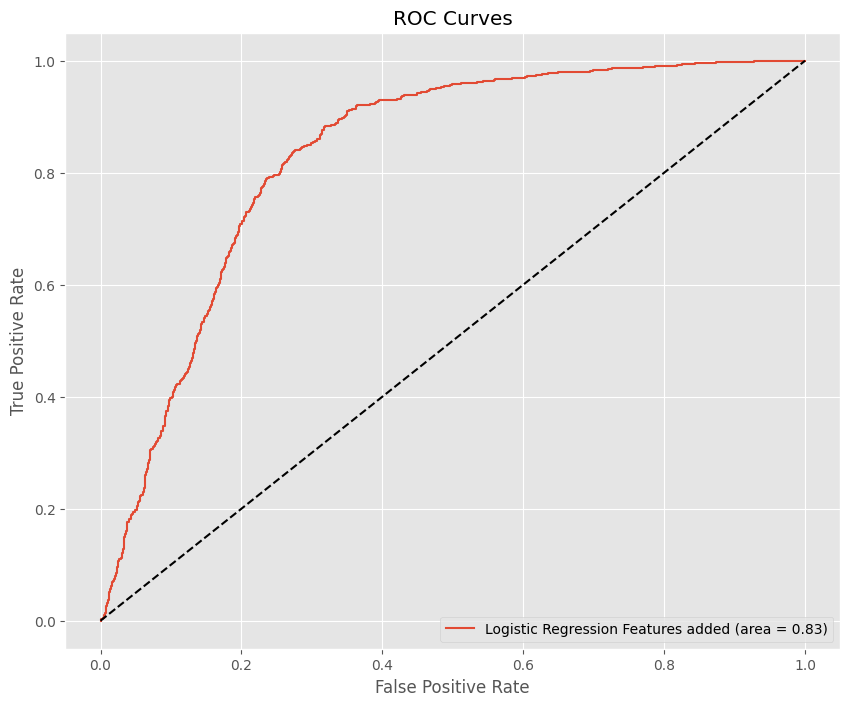

Best parameters for Logistic Regression Features added: {'model__C': 0.01}


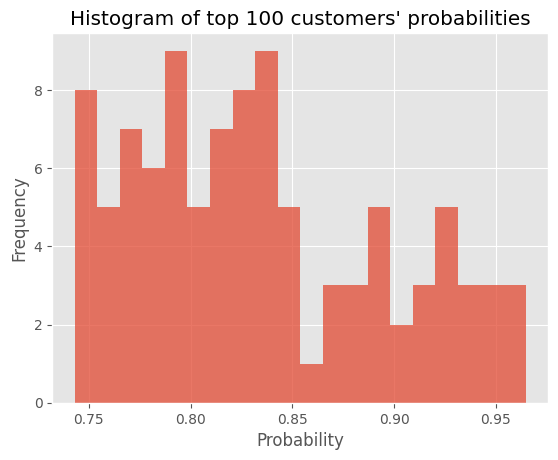

In [112]:
# Define models and their parameter grids
models = {
    "Logistic Regression Features added": LogisticRegression(solver="liblinear"),
}
param_grid = {
    "Logistic Regression Features added": {"model__C": [0.001, 0.01, 0.1, 1, 10]},
}

selected_fields = X_feature_engineered.columns

evaluator = ModelEvaluator(
    models, param_grid, X_feature_engineered, y, selected_fields=selected_fields
)
evaluator.evaluate_models()
evaluator.plot_roc_curves()
evaluator.optimize_model("Logistic Regression Features added")
evaluator.compare_top_n_customers("Logistic Regression Features added", n=100)


# Assuming X and y are defined
#

In [113]:
# check if there are any missing values
# print the missing values of withdrawal mean ration last3 first3
print(X_feature_engineered["withdrawal_mean_ratio_last3_first3"].isnull().sum())

# get the index of the missing values
missing_values = X_feature_engineered["withdrawal_mean_ratio_last3_first3"].isnull()
missing_values_index = X_feature_engineered[missing_values].index
print(missing_values_index)
X_feature_engineered.loc[missing_values_index]
# Transform the missing values to the mean of the column
X_feature_engineered["withdrawal_mean_ratio_last3_first3"] = X_feature_engineered[
    "withdrawal_mean_ratio_last3_first3"
].fillna(X_feature_engineered["withdrawal_mean_ratio_last3_first3"].mean())

display(X_feature_engineered.head(5))


0
Index([], dtype='int64')


type_disp frequency date_account  gender  birth_day  age   issued  \
0     OWNER   monthly   1995-03-24  female 1970-12-13   29      NaT   
1     OWNER   monthly   1993-02-26    male 1945-02-04   54      NaT   
2     OWNER   monthly   1997-07-07    male 1956-12-01   43      NaT   
3     OWNER   monthly   1996-11-24    male 1935-10-16   64  1998-10   
4     OWNER   monthly   1996-08-28  female 1974-05-29   25      NaT   

   date_loan   amount  duration  payments             status  household  \
0        NaT      NaN       NaN       NaN                NaN     2452.0   
1 1994-01-05  80952.0      24.0    3373.0  contract finished     7266.0   
2        NaT      NaN       NaN       NaN                NaN     1135.0   
3        NaT      NaN       NaN       NaN                NaN     4880.0   
4        NaT      NaN       NaN       NaN                NaN     7033.0   

   insurance_payment  leasing  loan_payment  unknown district_name_account  \
0                0.0      0.0           0.0      0.0                 Pisek   
1                0.0      0.0        3372.7      0.0           Hl.m. Praha   
2             3539.0      0.0           0.0    327.0                 Kolin   
3                0.0      0.0           0.0      0.0             Prostejov   
4                0.0   1344.0           0.0      0.0          Brno - mesto   

    region_account  num_of_habitat_account  num_of_small_town_account  \
0    south Bohemia                   70699                         60   
1           Prague                 1204953                          0   
2  central Bohemia                   95616                         65   
3    south Moravia                  110643                         49   
4    south Moravia                  387570                          0   

   num_of_medium_town_account  num_of_big_town_account  \
0                          13                        2   
1                           0                        0   
2                          30                        4   
3                          41                        4   
4                           0                        0   

   num_of_bigger_town_account  num_of_city_account  ratio_of_urban_account  \
0                           1                    4                    65.3   
1                           1                    1                   100.0   
2                           1                    6                    51.4   
3                           1                    4                    51.9   
4                           1                    1                   100.0   

   average_salary_account  unemploy_rate95_account  unemploy_rate96_account  \
0                    8968                     2.83                     3.35   
1                   12541                     0.29                     0.43   
2                    9307                     3.85                     4.43   
3                    8441                     3.45                     4.48   
4                    9897                     1.60                     1.96   

   n_of_enterpren_per1000_inhabit_account  no_of_crimes95_account  \
0                                     131                  1740.0   
1                                     167                 85677.0   
2                                     118                  2616.0   
3                                     115                  1879.0   
4                                     140                 18721.0   

   no_of_crimes96_account district_name_client    region_client  \
0                    1910                Pisek    south Bohemia   
1                   99107          Hl.m. Praha           Prague   
2                    3040                Kolin  central Bohemia   
3                    2252            Prostejov    south Moravia   
4                   18696         Brno - mesto    south Moravia   

   num_of_habitat_client  num_of_small_town_client  num_of_medium_town_client  \
0                  70699

Random Forest: ROC AUC = 0.88
Random Forest: Precision = 0.60
Random Forest: Recall = 0.48
Random Forest: Accuracy = 0.81
Random Forest: F-measure = 0.53
Random Forest: Kappa = 0.41
Random Forest: MCC = 0.42


c:\Users\super\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.036009806476869244, tolerance: 0.031896716899892416
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\super\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05018331925913344, tolerance: 0.031896716899892416
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\super\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.052556324362683426, tolerance: 0.031896716899892416
  model = cd_fast.enet_coordinate_d

Gradient Boosting: ROC AUC = 0.88
Gradient Boosting: Precision = 0.59
Gradient Boosting: Recall = 0.53
Gradient Boosting: Accuracy = 0.81
Gradient Boosting: F-measure = 0.56
Gradient Boosting: Kappa = 0.44
Gradient Boosting: MCC = 0.44


c:\Users\super\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.036009806476869244, tolerance: 0.031896716899892416
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\super\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05018331925913344, tolerance: 0.031896716899892416
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\super\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.052556324362683426, tolerance: 0.031896716899892416
  model = cd_fast.enet_coordinate_d

SVM: ROC AUC = 0.86
SVM: Precision = 0.57
SVM: Recall = 0.43
SVM: Accuracy = 0.80
SVM: F-measure = 0.49
SVM: Kappa = 0.37
SVM: MCC = 0.38


c:\Users\super\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.036009806476869244, tolerance: 0.031896716899892416
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\super\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05018331925913344, tolerance: 0.031896716899892416
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\super\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.052556324362683426, tolerance: 0.031896716899892416
  model = cd_fast.enet_coordinate_d

KNN: ROC AUC = 0.82
KNN: Precision = 0.50
KNN: Recall = 0.46
KNN: Accuracy = 0.78
KNN: F-measure = 0.48
KNN: Kappa = 0.34
KNN: MCC = 0.34


c:\Users\super\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.036009806476869244, tolerance: 0.031896716899892416
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\super\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05018331925913344, tolerance: 0.031896716899892416
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\super\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.052556324362683426, tolerance: 0.031896716899892416
  model = cd_fast.enet_coordinate_d

Decision Tree: ROC AUC = 0.68
Decision Tree: Precision = 0.51
Decision Tree: Recall = 0.50
Decision Tree: Accuracy = 0.78
Decision Tree: F-measure = 0.50
Decision Tree: Kappa = 0.37
Decision Tree: MCC = 0.37


c:\Users\super\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.036009806476869244, tolerance: 0.031896716899892416
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\super\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05018331925913344, tolerance: 0.031896716899892416
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\super\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.052556324362683426, tolerance: 0.031896716899892416
  model = cd_fast.enet_coordinate_d

AdaBoost: ROC AUC = 0.87
AdaBoost: Precision = 0.60
AdaBoost: Recall = 0.44
AdaBoost: Accuracy = 0.81
AdaBoost: F-measure = 0.49
AdaBoost: Kappa = 0.38
AdaBoost: MCC = 0.39


c:\Users\super\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.036009806476869244, tolerance: 0.031896716899892416
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\super\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05018331925913344, tolerance: 0.031896716899892416
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\super\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.052556324362683426, tolerance: 0.031896716899892416
  model = cd_fast.enet_coordinate_d

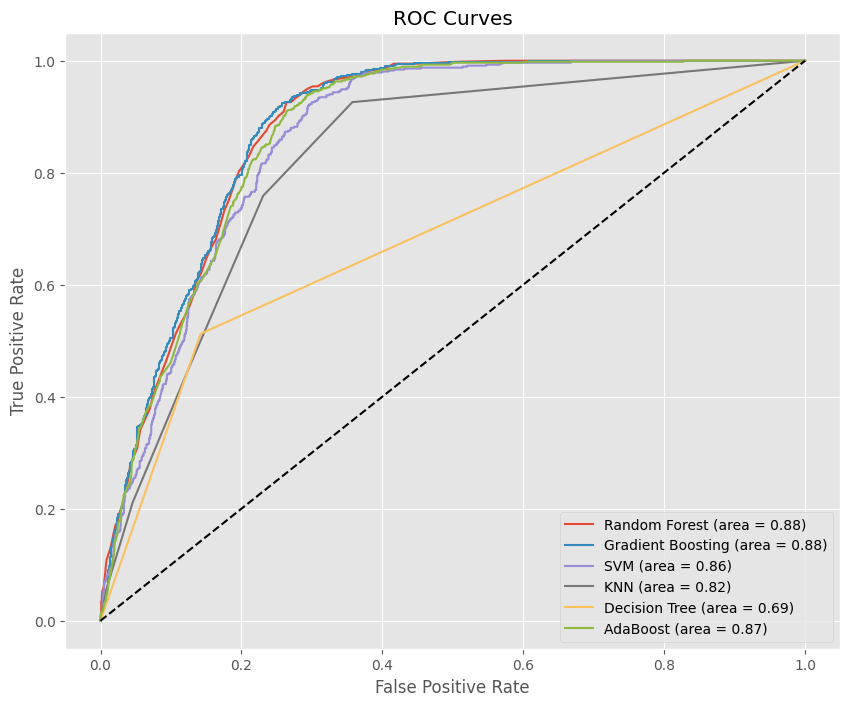

In [114]:
# Define models and their parameter grids
models = {
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "AdaBoost": AdaBoostClassifier(algorithm="SAMME"),
}

param_grid = {
    "Random Forest": {
        "model__n_estimators": [100, 200, 300],
        "model__max_depth": [None, 5, 10],
    },
    "Gradient Boosting": {
        "model__n_estimators": [100, 200, 300],
        "model__learning_rate": [0.1, 0.01, 0.001],
    },
    "SVM": {"model__C": [0.1, 1, 10], "model__kernel": ["linear", "rbf"]},
    "KNN": {"model__n_neighbors": [3, 5, 7], "model__weights": ["uniform", "distance"]},
    "Decision Tree": {
        "model__max_depth": [None, 5, 10],
        "model__min_samples_split": [2, 5, 10],
    },
    "AdaBoost": {
        "model__n_estimators": [50, 100, 150],
        "model__learning_rate": [0.1, 0.01, 0.001],
    },
}

# todo fix here the not converging models with LassoCV
for model_name, model in models.items():
    models[model_name] = Pipeline(
        [("feature_selection", SelectFromModel(LassoCV())), ("model", model)]
    )

selected_fields = X_feature_engineered.columns  # add the new features of df_features

evaluator_models = ModelEvaluator(
    models, param_grid, X_feature_engineered, y, selected_fields=selected_fields
)
results = evaluator_models.evaluate_models()
evaluator_models.plot_roc_curves()

# for model_name in tqdm(models.keys()):
#    best_models[model_name] = evaluator_models.optimize_model(model_name)

# best_model_name = max(best_models, key=best_models.get)
# best_model = best_models[best_model_name]

# get best model out of the best_models roc auc and precision
# best_model = max(best_models, key=lambda x: best_models[x].score(X, y))

# evaluator_models.compare_top_n_customers(best_model, n=100)
# evaluator_models
# Assuming X and y are defined
#

# Erklärbare Modelle

In [115]:
# todo fix the error

# Explain the best model with LIME
# evaluator_models.explain_with_lime("Random Forest")

# Explain the best model with SHAP
# evaluator_models.explain_with_shap("Random Forest")



## Results Comparision

ROC AUC  Precision    Recall  Accuracy  \
Baseline Logistic Regression        0.849224   0.510641  0.290570  0.782727   
Random Forest                       0.881962   0.597215  0.479355  0.814085   
Gradient Boosting                   0.881384   0.585595  0.533615  0.814482   
SVM                                 0.864999   0.568840  0.431610  0.802088   
KNN                                 0.820136   0.504969  0.457989  0.781166   
Decision Tree                       0.684626   0.511432  0.500407  0.784278   
AdaBoost                            0.872986   0.597103  0.436842  0.809070   
Logistic Regression Features added  0.831056   0.534512  0.360965  0.788146   

                                    F-measure     Kappa       MCC  
Baseline Logistic Regression         0.369525  0.250450  0.265250  
Random Forest                        0.528467  0.406223  0.421574  
Gradient Boosting                    0.557581  0.438539  0.438831  
SVM                                  0.487811  0.368679  0.375628  
KNN                                  0.479147  0.341341  0.342663  
Decision Tree                        0.499084  0.371398  0.368544  
AdaBoost                             0.491207  0.380462  0.394173  
Logistic Regression Features added   0.429068  0.304943  0.314896

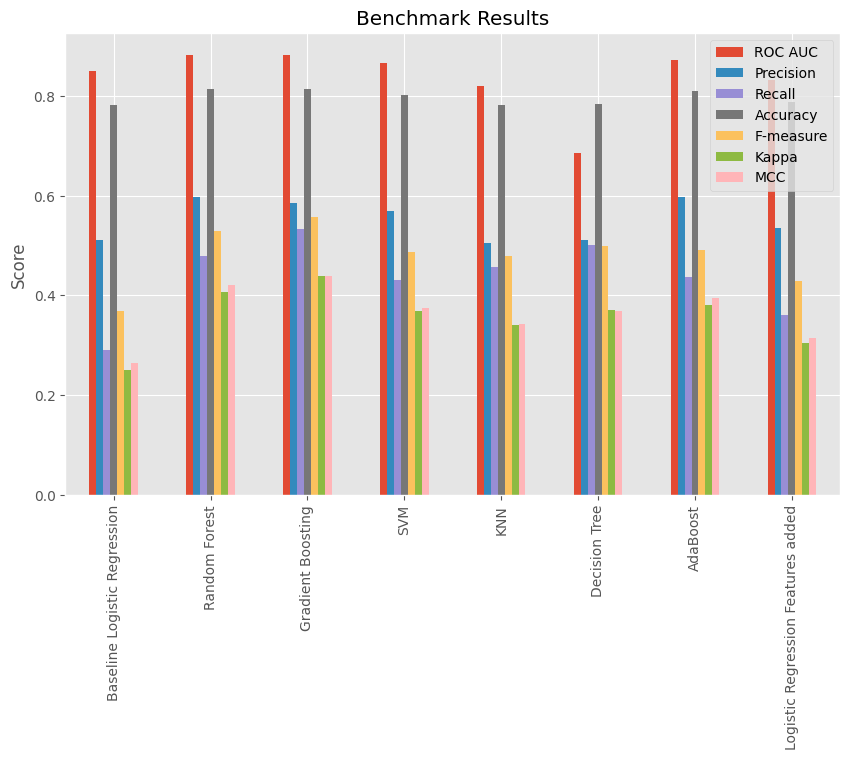

In [116]:
benchmark = MetricsBenchmarker()
benchmark.add_evaluator(evaluator_baseline)
benchmark.add_evaluator(evaluator_models)
benchmark.add_evaluator(evaluator)
benchmark.set_benchmark_results()
benchmark.display_benchmark_results_table()
benchmark.plot_benchmark_results_bar_chart()

In [117]:
evaluator_models.get_benchmark_results()

{'Random Forest': {'ROC AUC': 0.8819622574983341,
  'Precision': 0.5972151256948707,
  'Recall': 0.47935463659147864,
  'Accuracy': 0.814085181527042,
  'F-measure': 0.5284670075829909,
  'Kappa': 0.40622275023159454,
  'MCC': 0.42157439907216576},
 'Gradient Boosting': {'ROC AUC': 0.8813841441937932,
  'Precision': 0.5855954261244977,
  'Recall': 0.5336152882205514,
  'Accuracy': 0.8144817575050134,
  'F-measure': 0.5575814996723565,
  'Kappa': 0.43853854533133924,
  'MCC': 0.4388307841940947},
 'SVM': {'ROC AUC': 0.8649988814951521,
  'Precision': 0.5688398514052612,
  'Recall': 0.43161027568922306,
  'Accuracy': 0.802087635808566,
  'F-measure': 0.48781148757436166,
  'Kappa': 0.3686788735426329,
  'MCC': 0.3756280805186926},
 'KNN': {'ROC AUC': 0.8201356034352173,
  'Precision': 0.5049687325623446,
  'Recall': 0.4579887218045113,
  'Accuracy': 0.781166382329173,
  'F-measure': 0.47914732221763634,
  'Kappa': 0.34134123255210663,
  'MCC': 0.34266269336793664},
 'Decision Tree': {'RO

## Interpretation von den Resultaten

- todo

# Convert Notebook

In [118]:
%%capture
import subprocess
import pathlib
import os

try:
    file_path = pathlib.Path(os.path.basename(__file__))
except:
    file_path = pathlib.Path("AML_MC.ipynb")

# Check the file extension
if file_path.suffix == ".py":
    # If it's a Python script, convert it to a notebook
    try:
        subprocess.check_output(["jupytext", "--to", "notebook", str(file_path)])
        print("Converted to notebook.")
    except subprocess.CalledProcessError as e:
        print("Conversion failed. Error message:", e.output)
elif file_path.suffix == ".ipynb":
    # If it's a notebook, convert it to a Python script with cell markers
    try:
        subprocess.check_output(["jupytext", "--to", "py:percent", str(file_path)])
        print("Converted to Python script.")
    except subprocess.CalledProcessError as e:
        print("Conversion failed. Error message:", e.output)
else:
    print("Unsupported file type.")

In [119]:
import subprocess
import pathlib
import os

try:
    file_path = pathlib.Path(os.path.basename(__file__))
except:
    file_path = pathlib.Path("AML_MC.ipynb")

# Check the file extension
if file_path.suffix == ".qmd":
    # If it's a Python script, convert it to a notebook
    try:
        os.system("quarto convert AML_MC.qmd")
        print("Converted to notebook.")
    except subprocess.CalledProcessError as e:
        print("Conversion failed. Error message:", e.output)
elif file_path.suffix == ".ipynb":
    # If it's a notebook, convert it to a Python script with cell markers
    try:
        # quatro convert ipynb to qmd
        os.system("quarto convert AML_MC.ipynb")
        print("Converted to qmd.")
    except subprocess.CalledProcessError as e:
        print("Conversion failed. Error message:", e.output)
else:
    print("Unsupported file type.")


Converted to qmd.


In [120]:
import os

os.system("quarto render AML_MC.ipynb --to html")


0

# Referenzen
- [1] [Applied Predictive Modelling](http://link.springer.com/10.1007/978-1-4614-6849-3)